In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%matplotlib inline

In [3]:
from scipy import stats
import matplotlib.mlab as mlab

In [4]:
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

In [5]:
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [6]:
### import the data

cigna_agg = pd.read_csv("cigna_agg_final.txt", header = 0, sep="|")

In [7]:
cigna_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8381 entries, 0 to 8380
Data columns (total 65 columns):
member.id                    8381 non-null object
p12m.days                    8381 non-null int64
dob                          8381 non-null object
age                          8381 non-null int64
eff.date                     8381 non-null object
term.date                    8381 non-null object
gender                       8381 non-null object
gender.male                  8381 non-null int64
language                     8380 non-null object
lang.english                 8381 non-null int64
lang.spanish                 8381 non-null int64
ProductType                  5180 non-null object
OperationalMarket            5180 non-null object
relToSubs                    8381 non-null object
sourceDesc                   8381 non-null object
state                        8381 non-null object
state.TN                     8381 non-null int64
zip                          8381 non-null int64


In [8]:
cigna_agg.columns = cigna_agg.columns.str.replace(".", "_")

In [9]:
### filter the data

agg = cigna_agg[(cigna_agg["p12m_days"] > 360) & (cigna_agg['total_cost'] >= 0) & (cigna_agg['prof_cost'] >= 0) & (cigna_agg['rx_cost'] >= 0)].reset_index()

In [10]:
agg.shape  #(7367, 66)

(7367, 66)

In [11]:
agg = agg[agg.state.isin(['TN', "TX"])].reset_index()

In [12]:
agg.shape  #(7088, 66)

(7088, 67)

In [13]:
### create comorbidity index variables

comorCntCols =['SUD_cnt', 'Anxiety_cnt', 'Depression_cnt', 'Asthma_cnt', 'CHF_cnt', 'CAD_cnt', 'COPD_cnt', 'Diabetes_cnt',
            'Pneumonia_cnt', 'Gallbladder_cnt', 'Inju_Pois_cnt', 'External_cnt', 'Arthritis_cnt', 'Chro_Pain_cnt', 
            'Smoking_cnt', 'Obesity_cnt', 'Bipolar_cnt', 'Hypertension_cnt', 'Adjustment_cnt', 'ADHD_cnt', 'Dementia_cnt', 
            'Development_cnt', 'Personal_cnt', 'Schizophrenia_cnt', 'Suicide_cnt', 'Mental_Retard_cnt', 'Other_Psych_cnt']


In [14]:
comorIndCols = []
for i in range(len(comorCntCols)):
    s = "_".join(comorCntCols[i].split('_')[:-1]) + '_ind'
    comorIndCols.append(s)
    agg[s] = np.where(agg[comorCntCols[i]] > 0, 1, 0)



In [15]:
### explore the demographic variables

365    7088
Name: p12m_days, dtype: int64


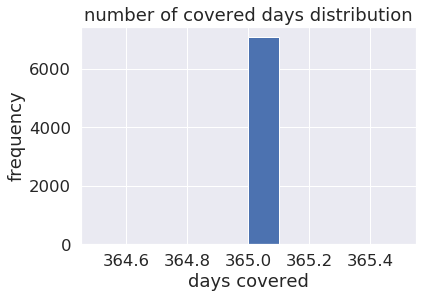

In [16]:
print(agg.p12m_days.value_counts())

ax = plt.hist(agg.p12m_days, bins=10)
plt.title('number of covered days distribution')
plt.xlabel('days covered')
plt.ylabel('frequency')
plt.show()


In [17]:
## number of members in each state 
state_cnt = agg.groupby("state").size().reset_index(name = "count")
state_cnt


state  count
0    TN   3192
1    TX   3896

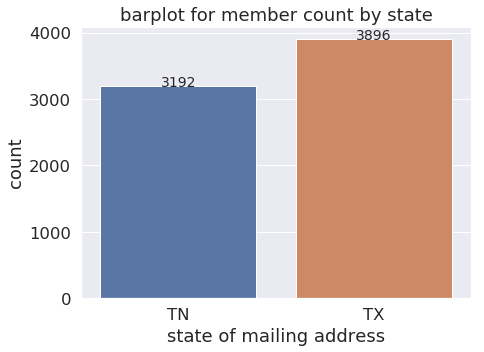

In [18]:

plt.figure(figsize=(7,5))
ax = sns.barplot(x='state', y='count', data=state_cnt)
ax.set_title("barplot for member count by state")
ax.set_xlabel("state of mailing address")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height +1,
           int(height),
           ha='center',
           size=14)
    

In [19]:
### number of members in each state by gender
state_gender_cnt = agg.groupby(['state', 'gender']).size().reset_index(name='count')
state_gender_cnt

state gender  count
0    TN      F   2100
1    TN      M   1092
2    TX      F   2565
3    TX      M   1331

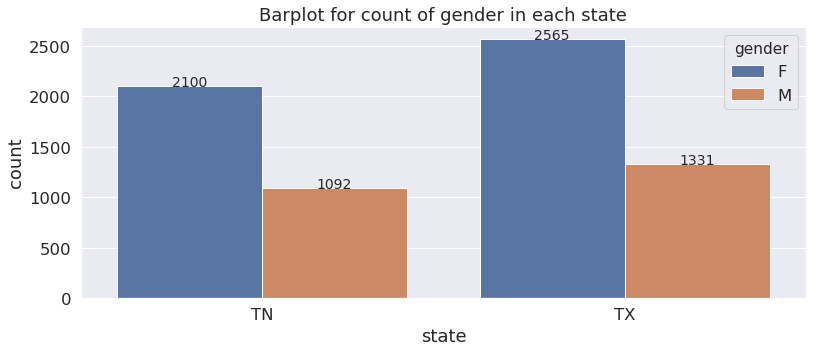

In [20]:

plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y='count', hue='gender', data = state_gender_cnt)
ax.set_title("Barplot for count of gender in each state")
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height +1,
           int(height),
           ha='center',
           size=14)

In [21]:
### language distribution by state
state_language_cnt = agg.groupby(['state', 'language']).size().reset_index(name = 'count')
state_language_cnt

state language  count
0    TN  BRAILLE      1
1    TN  ENGLISH   3188
2    TN  SPANISH      3
3    TX  ENGLISH   3280
4    TX  SPANISH    615
5    TX     THAI      1

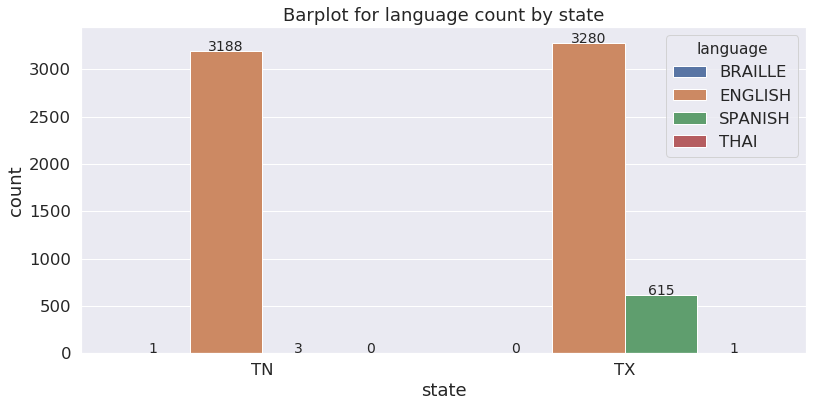

In [22]:

plt.figure(figsize=(13,6))
ax = sns.barplot(x='state', y='count', hue='language', data = state_language_cnt)
ax.set_title('Barplot for language count by state')
ax.set_xlabel('state')

for p in ax.patches:
    height = np.where(np.isnan(p.get_height()), 0, p.get_height())    
    ax.text(p.get_x() + p.get_width()/2.,
           height+1,
           int(height),
           ha='center',
           size=14)

In [23]:
### language distribution by state
gender_language_cnt = agg.groupby(['gender', 'language']).size().reset_index(name = 'count')
gender_language_cnt

gender language  count
0      F  BRAILLE      1
1      F  ENGLISH   4258
2      F  SPANISH    405
3      F     THAI      1
4      M  ENGLISH   2210
5      M  SPANISH    213

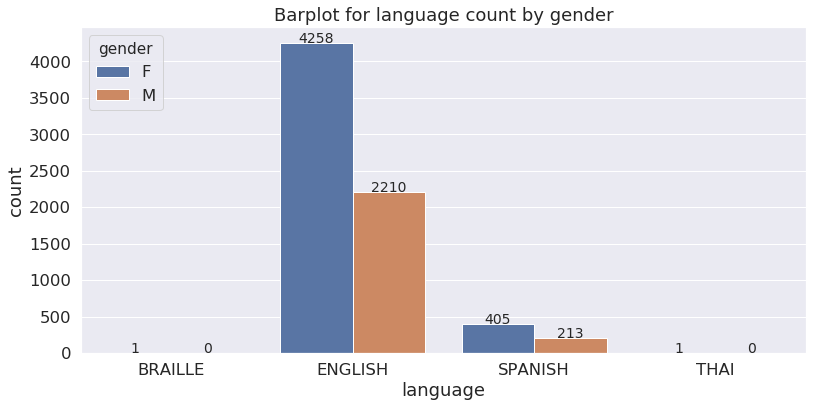

In [24]:

plt.figure(figsize=(13,6))
ax = sns.barplot(x='language', y='count', hue='gender', data = gender_language_cnt)
ax.set_title('Barplot for language count by gender')
ax.set_xlabel('language')

for p in ax.patches:
    height = np.where(np.isnan(p.get_height()), 0, p.get_height())    
    ax.text(p.get_x() + p.get_width()/2.,
           height+1,
           int(height),
           ha='center',
           size=14)

In [25]:
### number of rural member in each state
state_rural_cnt = agg.groupby(['state', 'rural']).size().reset_index(name='count')
state_rural_cnt

state  rural  count
0    TN      0   2331
1    TN      1    861
2    TX      0   3163
3    TX      1    733

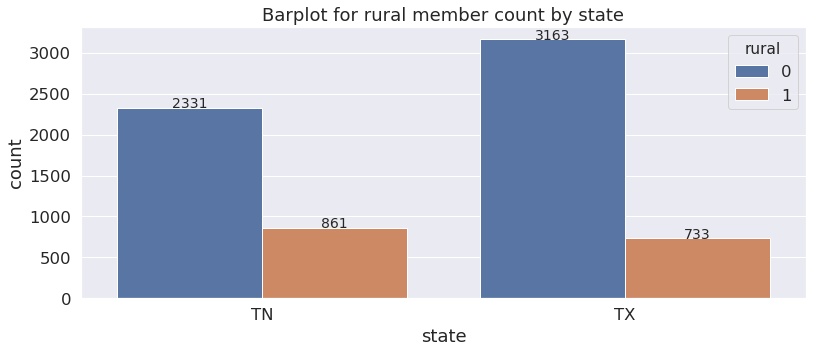

In [26]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y='count', hue='rural', data = state_rural_cnt)
ax.set_title('Barplot for rural member count by state')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+1,
           int(height),
           ha='center',
           size=14)


In [27]:
print(861.0/(2331+861))
print(733.0/(3163+733))

0.269736842105
0.188141683778


In [28]:
### number of rural member in each state
gender_rural_cnt = agg.groupby(['gender', 'rural']).size().reset_index(name='count')
gender_rural_cnt

gender  rural  count
0      F      0   3600
1      F      1   1065
2      M      0   1894
3      M      1    529

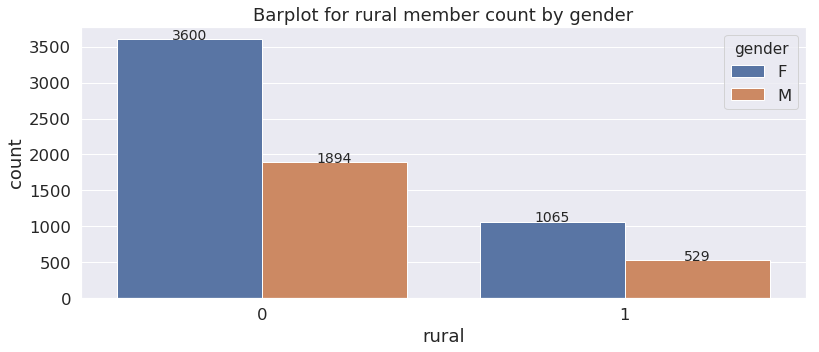

In [29]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='rural', y='count', hue='gender', data = gender_rural_cnt)
ax.set_title('Barplot for rural member count by gender')
ax.set_xlabel('rural')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+1,
           int(height),
           ha='center',
           size=14)


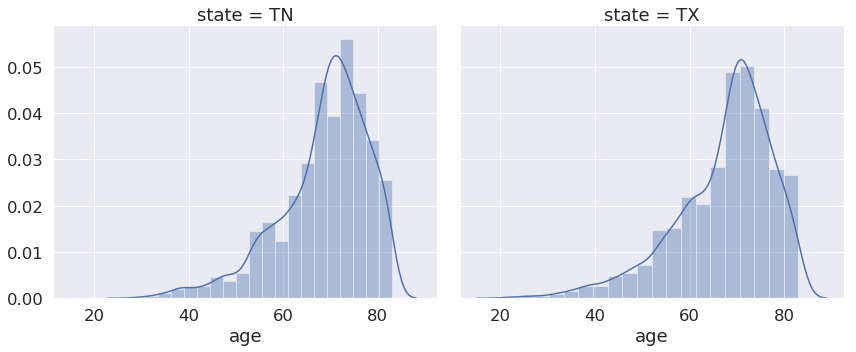

In [30]:
####  age 
g = sns.FacetGrid(agg, col="state", palette="Set1", height=5, aspect =1.2)
g = (g.map(sns.distplot, "age", bins =20, hist=True, kde=True, rug=False))
plt.show()

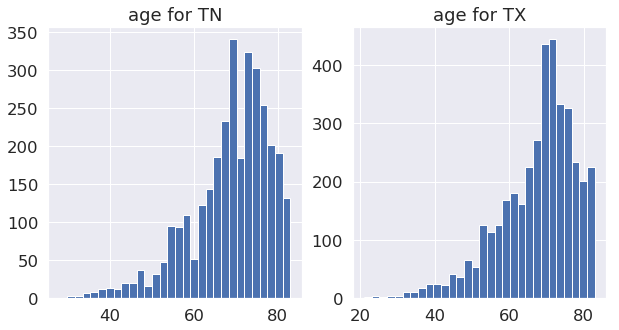

In [31]:

plt.figure(figsize = (10, 5))
states = agg.state.unique()
for i in range(len(states)):
    ax=plt.subplot(1,2,i+1)
    plt.hist(agg.loc[agg.state == states[i], 'age'], bins=30)
    plt.title('age for '+ states[i])
plt.show()


In [32]:
print((agg.age < 65).sum())
print(sum((agg.age >= 65) & (agg.age < 75)))
print(sum(agg.age >=75))


2043
3146
1899


In [33]:
agg['ageLt65'] = np.where(agg.age < 65, 1, 0)
agg.ageLt65.value_counts()


0    5045
1    2043
Name: ageLt65, dtype: int64

In [34]:
ind_65_75 = (agg.age >= 65) & (agg.age<75)
agg['age65to75'] = np.where(ind_65_75, 1, 0) 
agg.age65to75.value_counts()


0    3942
1    3146
Name: age65to75, dtype: int64

In [35]:
state_gender_age_median = agg.groupby(['state', 'gender']).age.median().reset_index(name='median')
state_gender_age_median


state gender  median
0    TN      F      71
1    TN      M      69
2    TX      F      70
3    TX      M      68

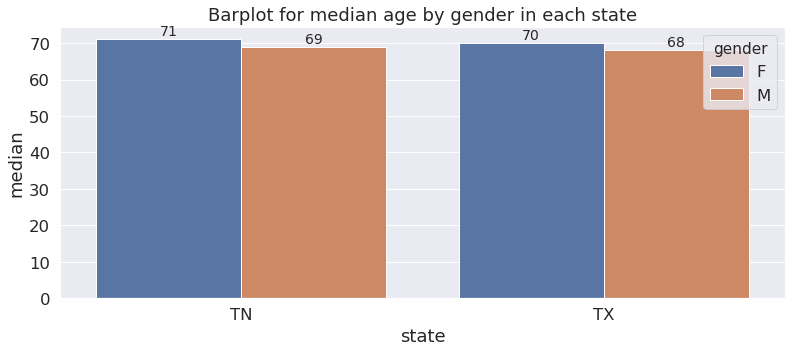

In [36]:


plt.figure(figsize=(13,5))
ax = sns.barplot(x='state',y='median',hue='gender', data=state_gender_age_median)
ax.set_title('Barplot for median age by gender in each state')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
           height+1,
           int(height),
           ha='center',
           size=14)

In [37]:
#### exploratory data analysis for comorbidity

In [38]:
for i in range(len(comorIndCols)):
    print(agg[comorIndCols[i]].value_counts())


0    5216
1    1872
Name: SUD_ind, dtype: int64
1    4348
0    2740
Name: Anxiety_ind, dtype: int64
1    4545
0    2543
Name: Depression_ind, dtype: int64
0    6161
1     927
Name: Asthma_ind, dtype: int64
0    5418
1    1670
Name: CHF_ind, dtype: int64
0    4268
1    2820
Name: CAD_ind, dtype: int64
0    4627
1    2461
Name: COPD_ind, dtype: int64
0    3899
1    3189
Name: Diabetes_ind, dtype: int64
0    6047
1    1041
Name: Pneumonia_ind, dtype: int64
0    6683
1     405
Name: Gallbladder_ind, dtype: int64
0    3713
1    3375
Name: Inju_Pois_ind, dtype: int64
0    3657
1    3431
Name: External_ind, dtype: int64
0    6586
1     502
Name: Arthritis_ind, dtype: int64
0    4723
1    2365
Name: Chro_Pain_ind, dtype: int64
0    6365
1     723
Name: Smoking_ind, dtype: int64
0    7088
Name: Obesity_ind, dtype: int64
0    6397
1     691
Name: Bipolar_ind, dtype: int64
1    6295
0     793
Name: Hypertension_ind, dtype: int64
0    6818
1     270
Name: Adjustment_ind, dtype: int64
0    7002
1  

In [39]:
for i in range(len(comorIndCols)):
    print(agg[comorIndCols[i]].value_counts(normalize=True))

0    0.735892
1    0.264108
Name: SUD_ind, dtype: float64
1    0.613431
0    0.386569
Name: Anxiety_ind, dtype: float64
1    0.641225
0    0.358775
Name: Depression_ind, dtype: float64
0    0.869216
1    0.130784
Name: Asthma_ind, dtype: float64
0    0.764391
1    0.235609
Name: CHF_ind, dtype: float64
0    0.602144
1    0.397856
Name: CAD_ind, dtype: float64
0    0.652793
1    0.347207
Name: COPD_ind, dtype: float64
0    0.550085
1    0.449915
Name: Diabetes_ind, dtype: float64
0    0.853132
1    0.146868
Name: Pneumonia_ind, dtype: float64
0    0.942861
1    0.057139
Name: Gallbladder_ind, dtype: float64
0    0.523843
1    0.476157
Name: Inju_Pois_ind, dtype: float64
0    0.515942
1    0.484058
Name: External_ind, dtype: float64
0    0.929176
1    0.070824
Name: Arthritis_ind, dtype: float64
0    0.666337
1    0.333663
Name: Chro_Pain_ind, dtype: float64
0    0.897997
1    0.102003
Name: Smoking_ind, dtype: float64
0    1.0
Name: Obesity_ind, dtype: float64
0    0.902511
1    0.09748

In [40]:
sud_mems = agg.groupby(["state","gender"]).SUD_ind.mean().reset_index(name = "count")
sud_mems

state gender     count
0    TN      F  0.169048
1    TN      M  0.352564
2    TX      F  0.215205
3    TX      M  0.435763

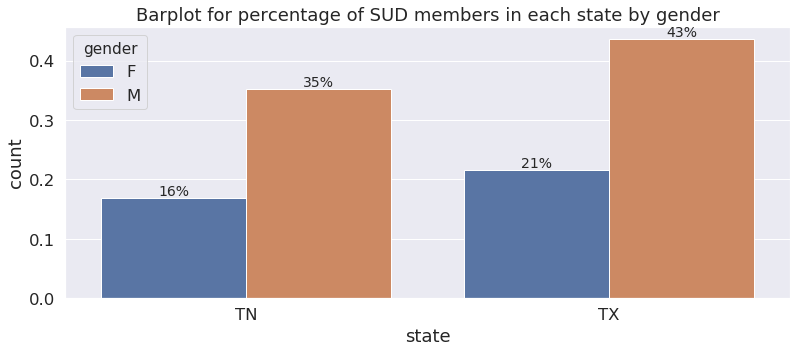

In [41]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y='count', hue='gender', data = sud_mems)
ax.set_title("Barplot for percentage of SUD members in each state by gender")
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height +0.005,
           str(int(height*100)) + '%',
           ha='center',
           size=14)
    

In [42]:
an_mems = agg.groupby(["state","gender"]).Anxiety_ind.mean().reset_index(name = "count")
an_mems

state gender     count
0    TN      F  0.700000
1    TN      M  0.548535
2    TX      F  0.619103
3    TX      M  0.519159

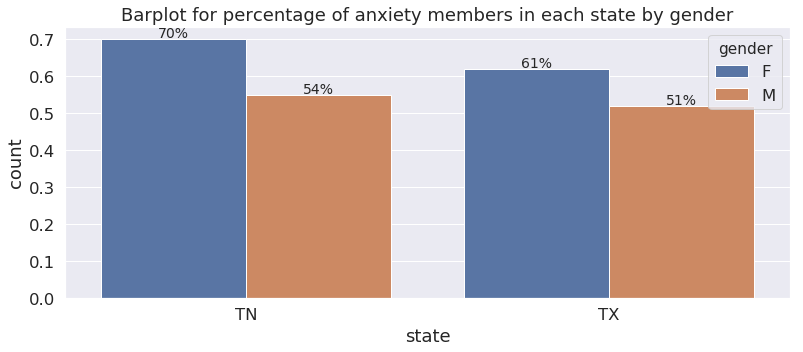

In [43]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue='gender', data = an_mems)
ax.set_title('Barplot for percentage of anxiety members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.005,
           str(int(height*100)) + '%',
            size = 14,
            ha = 'center'
           )

In [44]:
dp_mems = agg.groupby(['state', 'gender']).Depression_ind.mean().reset_index(name='count')
dp_mems

state gender     count
0    TN      F  0.667143
1    TN      M  0.530220
2    TX      F  0.709942
3    TX      M  0.558978

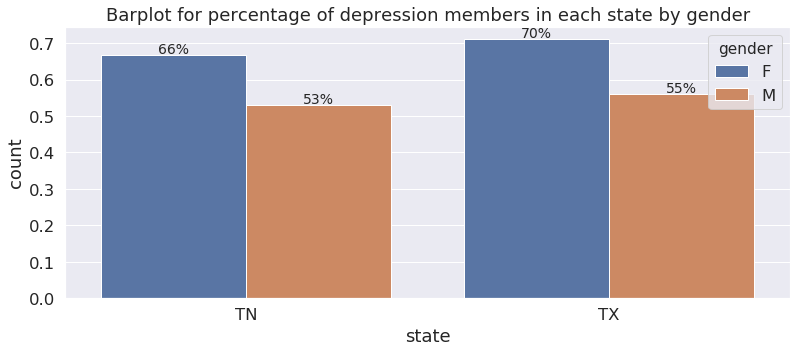

In [45]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue='gender', data = dp_mems)
ax.set_title('Barplot for percentage of depression members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.005,
           str(int(height*100))+'%',
           ha='center',
           size=14)


In [46]:
asthma_mems = agg.groupby(['state', 'gender']).Asthma_ind.mean().reset_index(name='count')
asthma_mems

state gender     count
0    TN      F  0.150476
1    TN      M  0.065934
2    TX      F  0.167641
3    TX      M  0.081893

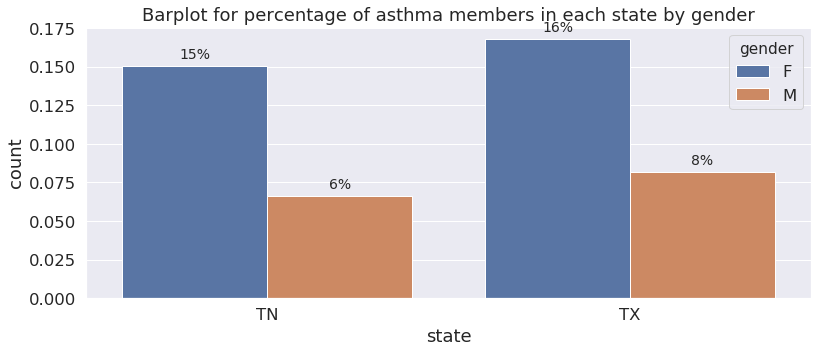

In [47]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = asthma_mems)
ax.set_title('Barplot for percentage of asthma members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.005,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [48]:
chf_mems = agg.groupby(['state', 'gender']).CHF_ind.mean().reset_index(name='count')
chf_mems

state gender     count
0    TN      F  0.219048
1    TN      M  0.276557
2    TX      F  0.221053
3    TX      M  0.256198

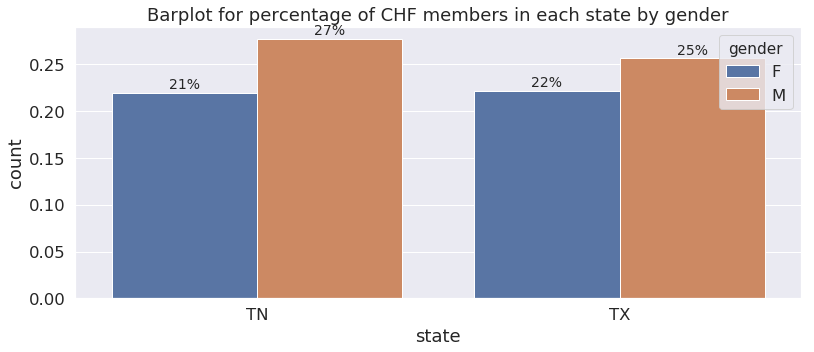

In [49]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = chf_mems)
ax.set_title('Barplot for percentage of CHF members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.005,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [50]:
cad_mems = agg.groupby(['state', 'gender']).CAD_ind.mean().reset_index(name='count')
cad_mems

state gender     count
0    TN      F  0.358571
1    TN      M  0.511905
2    TX      F  0.338791
3    TX      M  0.480090

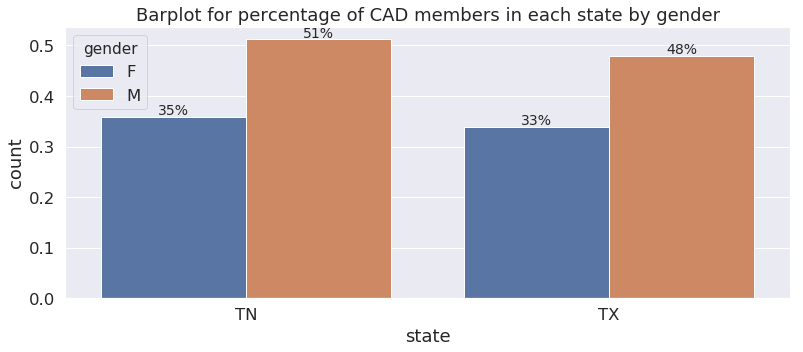

In [51]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = cad_mems)
ax.set_title('Barplot for percentage of CAD members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.005,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [52]:
copd_mems = agg.groupby(['state', 'gender']).COPD_ind.mean().reset_index(name='count')
copd_mems

state gender     count
0    TN      F  0.344286
1    TN      M  0.364469
2    TX      F  0.334893
3    TX      M  0.361382

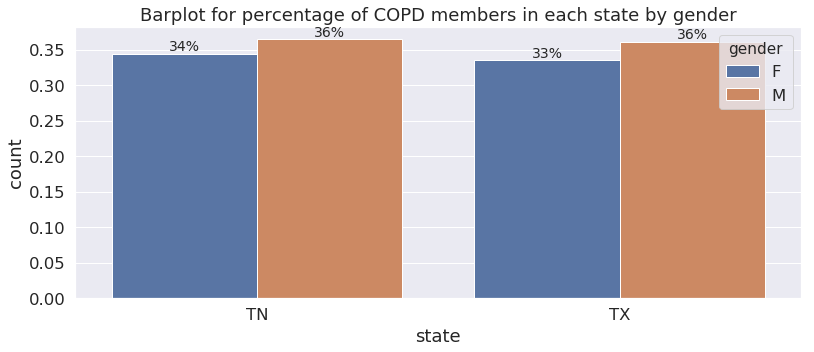

In [53]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = copd_mems)
ax.set_title('Barplot for percentage of COPD members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.005,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [54]:
diabetes_mems = agg.groupby(['state', 'gender']).Diabetes_ind.mean().reset_index(name='count')
diabetes_mems

state gender     count
0    TN      F  0.384286
1    TN      M  0.457875
2    TX      F  0.476803
3    TX      M  0.495116

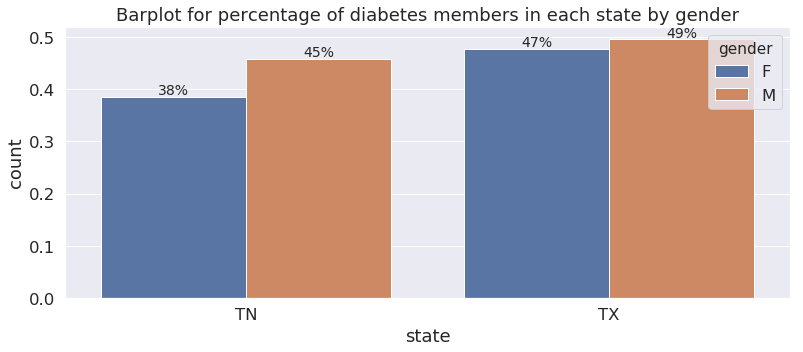

In [55]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = diabetes_mems)
ax.set_title('Barplot for percentage of diabetes members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.005,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [56]:
pneumonia_mems = agg.groupby(['state', 'gender']).Pneumonia_ind.mean().reset_index(name='count')
pneumonia_mems

state gender     count
0    TN      F  0.160476
1    TN      M  0.172161
2    TX      F  0.128655
3    TX      M  0.139745

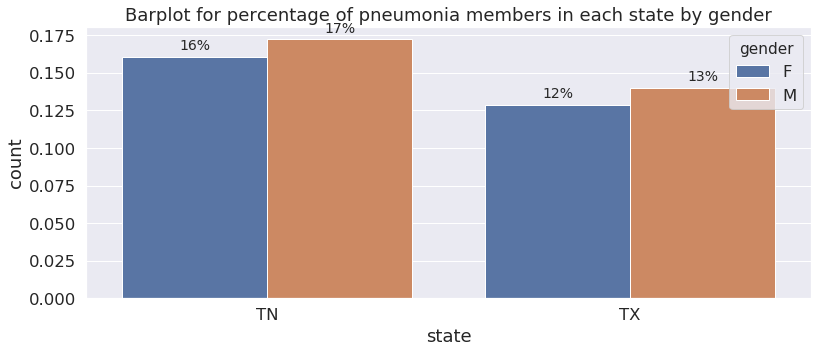

In [57]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = pneumonia_mems)
ax.set_title('Barplot for percentage of pneumonia members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.005,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [58]:
gallbladder_mems = agg.groupby(['state', 'gender']).Gallbladder_ind.mean().reset_index(name='count')
gallbladder_mems

state gender     count
0    TN      F  0.040476
1    TN      M  0.061355
2    TX      F  0.057310
3    TX      M  0.079639

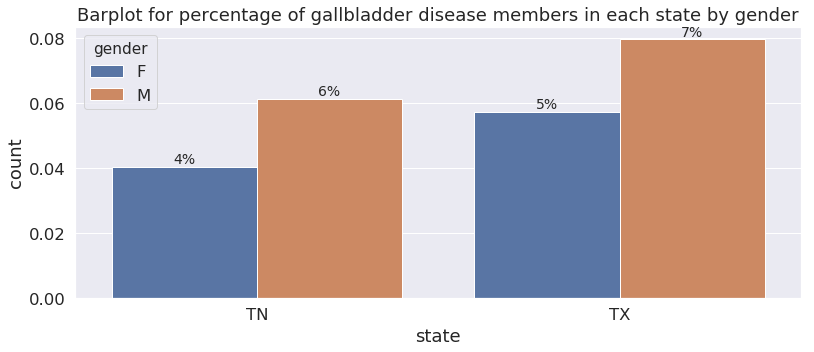

In [59]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = gallbladder_mems)
ax.set_title('Barplot for percentage of gallbladder disease members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.001,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [60]:
inju_pois_mems = agg.groupby(['state', 'gender']).Inju_Pois_ind.mean().reset_index(name='count')
inju_pois_mems

state gender     count
0    TN      F  0.469048
1    TN      M  0.481685
2    TX      F  0.474464
3    TX      M  0.486101

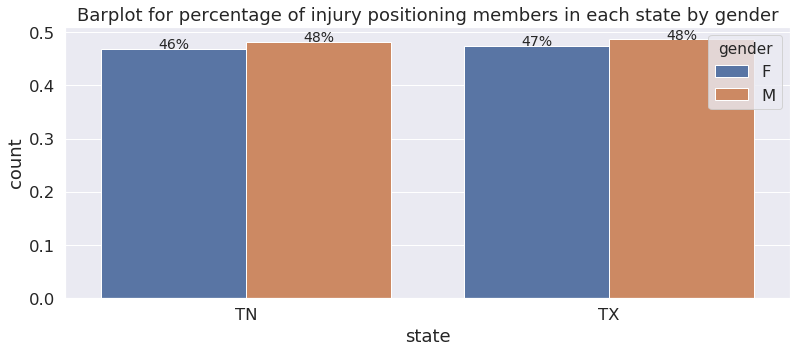

In [61]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = inju_pois_mems)
ax.set_title('Barplot for percentage of injury positioning members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.001,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [62]:
external_mems = agg.groupby(['state', 'gender']).External_ind.mean().reset_index(name='count')
external_mems

state gender     count
0    TN      F  0.526667
1    TN      M  0.533883
2    TX      F  0.440156
3    TX      M  0.460556

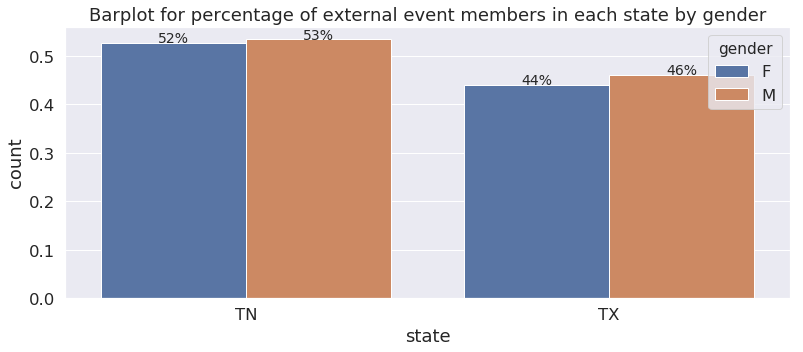

In [63]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = external_mems)
ax.set_title('Barplot for percentage of external event members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.001,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [64]:
arthritis_mems = agg.groupby(['state', 'gender']).Arthritis_ind.mean().reset_index(name='count')
arthritis_mems

state gender     count
0    TN      F  0.070952
1    TN      M  0.041209
2    TX      F  0.100195
3    TX      M  0.038317

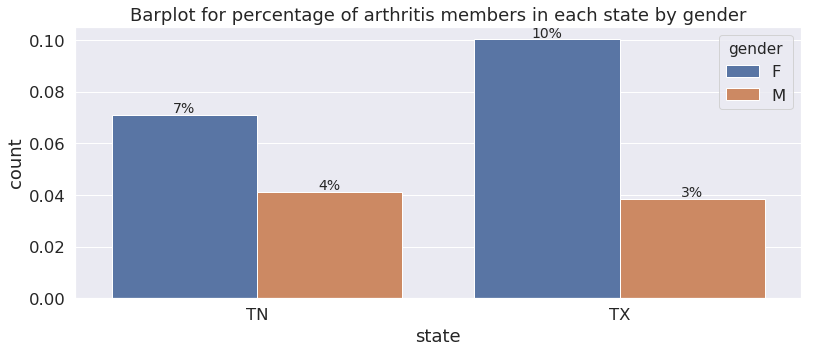

In [65]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = arthritis_mems)
ax.set_title('Barplot for percentage of arthritis members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.001,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [66]:
chro_pain_mems = agg.groupby(['state', 'gender']).Chro_Pain_ind.mean().reset_index(name='count')
chro_pain_mems

state gender     count
0    TN      F  0.363810
1    TN      M  0.330586
2    TX      F  0.329045
3    TX      M  0.297521

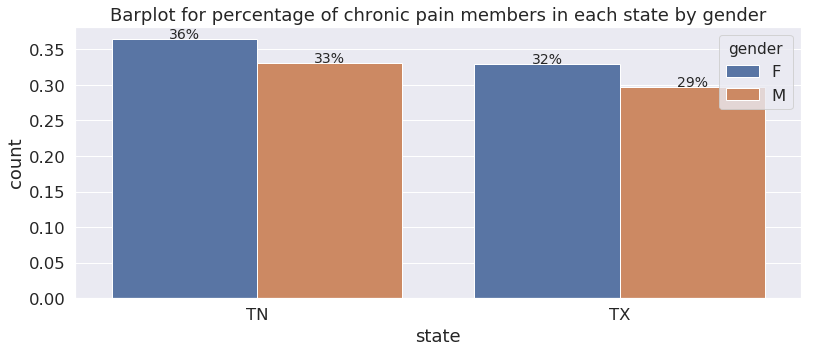

In [67]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = chro_pain_mems)
ax.set_title('Barplot for percentage of chronic pain members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.001,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [68]:
smoking_mems = agg.groupby(['state', 'gender']).Smoking_ind.mean().reset_index(name='count')
smoking_mems

state gender     count
0    TN      F  0.098095
1    TN      M  0.143773
2    TX      F  0.079142
3    TX      M  0.117956

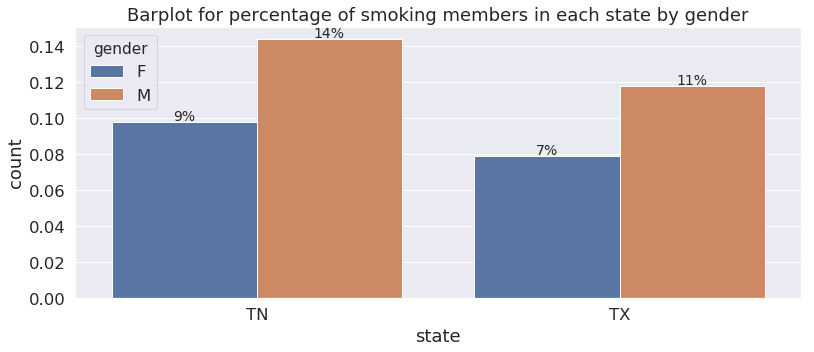

In [69]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = smoking_mems)
ax.set_title('Barplot for percentage of smoking members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.001,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [70]:
bipolar_mems = agg.groupby(['state', 'gender']).Bipolar_ind.mean().reset_index(name='count')
bipolar_mems

state gender     count
0    TN      F  0.090476
1    TN      M  0.078755
2    TX      F  0.110721
3    TX      M  0.098422

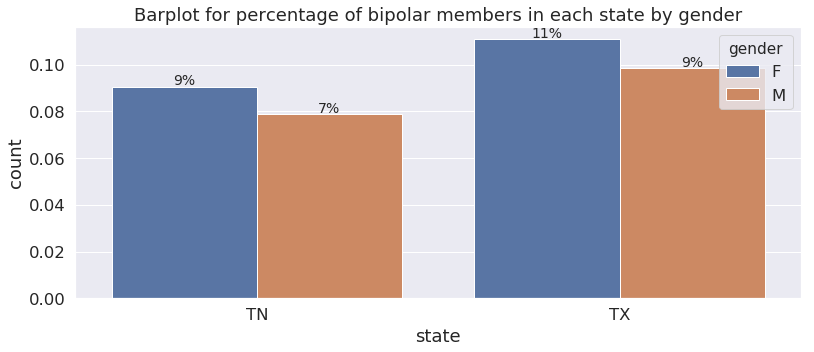

In [71]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = bipolar_mems)
ax.set_title('Barplot for percentage of bipolar members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.001,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [72]:
hypertension_mems = agg.groupby(['state', 'gender']).Hypertension_ind.mean().reset_index(name='count')
hypertension_mems

state gender     count
0    TN      F  0.862857
1    TN      M  0.910256
2    TX      F  0.891618
3    TX      M  0.903080

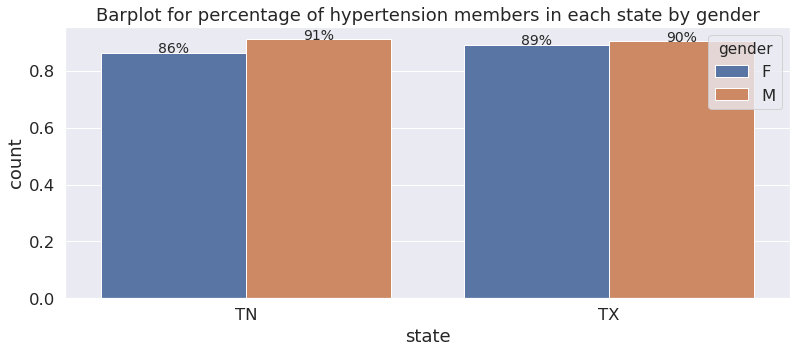

In [73]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = hypertension_mems)
ax.set_title('Barplot for percentage of hypertension members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.001,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [74]:
adjustment_mems = agg.groupby(['state', 'gender']).Adjustment_ind.mean().reset_index(name='count')
adjustment_mems

state gender     count
0    TN      F  0.031429
1    TN      M  0.044872
2    TX      F  0.042495
3    TX      M  0.034560

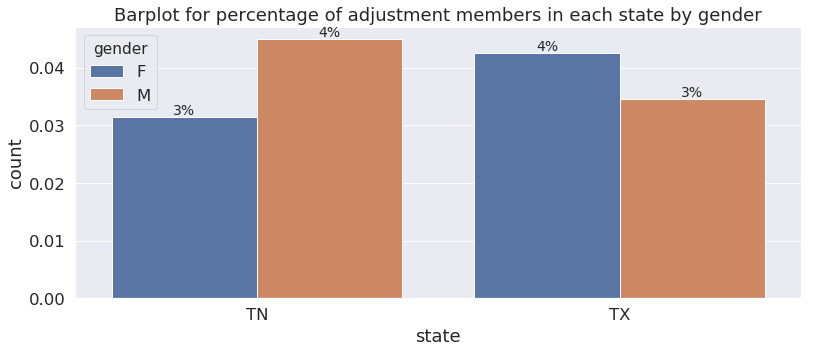

In [75]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = adjustment_mems)
ax.set_title('Barplot for percentage of adjustment members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.0005,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [76]:
adhd_mems = agg.groupby(['state', 'gender']).ADHD_ind.mean().reset_index(name='count')
adhd_mems

state gender     count
0    TN      F  0.009048
1    TN      M  0.010073
2    TX      F  0.013255
3    TX      M  0.016529

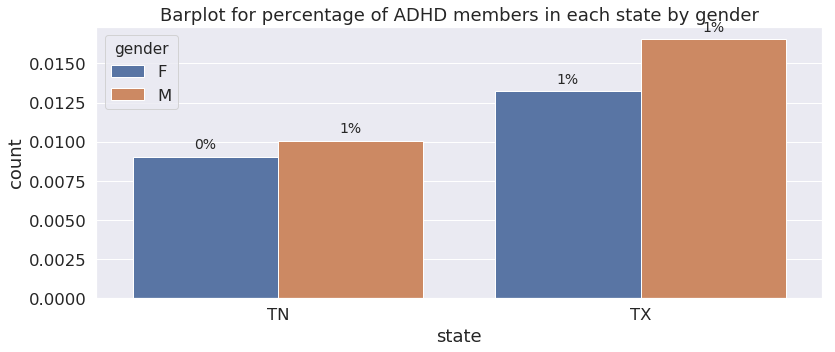

In [77]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = adhd_mems)
ax.set_title('Barplot for percentage of ADHD members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.0005,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [78]:
dementia_mems = agg.groupby(['state', 'gender']).Dementia_ind.mean().reset_index(name='count')
dementia_mems

state gender     count
0    TN      F  0.024286
1    TN      M  0.031136
2    TX      F  0.028070
3    TX      M  0.033058

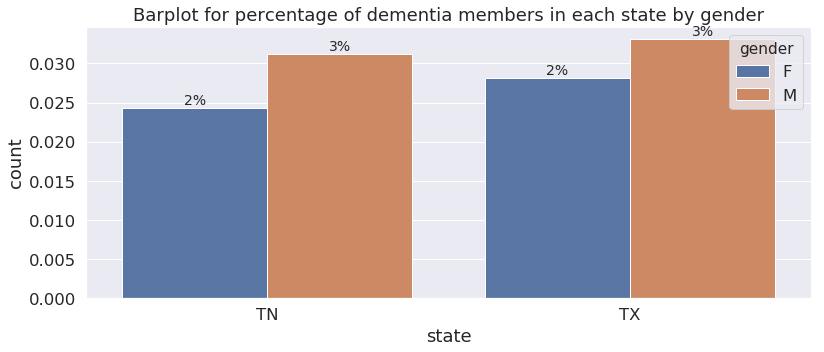

In [79]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = dementia_mems)
ax.set_title('Barplot for percentage of dementia members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.0005,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [80]:
development_mems = agg.groupby(['state', 'gender']).Development_ind.mean().reset_index(name='count')
development_mems

state gender     count
0    TN      F  0.013810
1    TN      M  0.024725
2    TX      F  0.016374
3    TX      M  0.034560

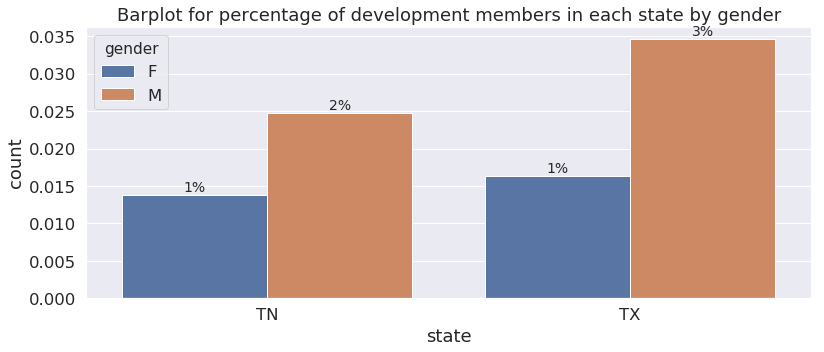

In [81]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = development_mems)
ax.set_title('Barplot for percentage of development members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.0005,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [82]:
personal_mems = agg.groupby(['state', 'gender']).Personal_ind.mean().reset_index(name='count')
personal_mems

state gender     count
0    TN      F  0.010476
1    TN      M  0.010073
2    TX      F  0.012476
3    TX      M  0.009767

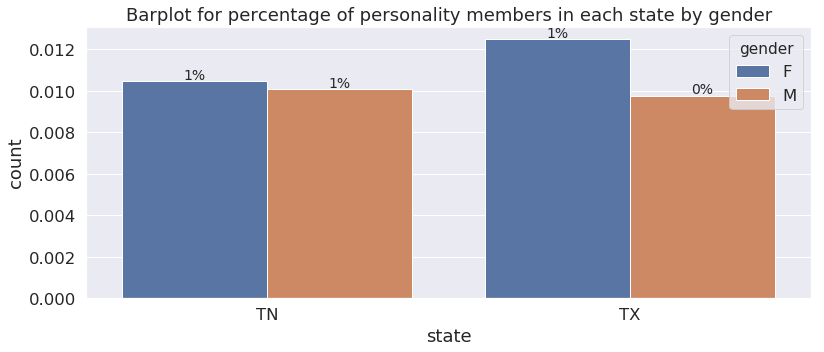

In [83]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = personal_mems)
ax.set_title('Barplot for percentage of personality members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.0001,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [84]:
schizophrenia_mems = agg.groupby(['state', 'gender']).Schizophrenia_ind.mean().reset_index(name='count')
schizophrenia_mems

state gender     count
0    TN      F  0.023810
1    TN      M  0.039377
2    TX      F  0.033918
3    TX      M  0.054846

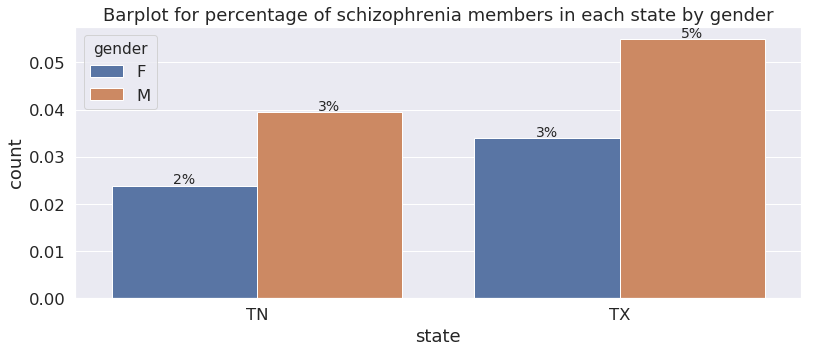

In [85]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = schizophrenia_mems)
ax.set_title('Barplot for percentage of schizophrenia members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.0005,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [86]:
suicide_mems = agg.groupby(['state', 'gender']).Suicide_ind.mean().reset_index(name='count')
suicide_mems

state gender     count
0    TN      F  0.002857
1    TN      M  0.007326
2    TX      F  0.000780
3    TX      M  0.000751

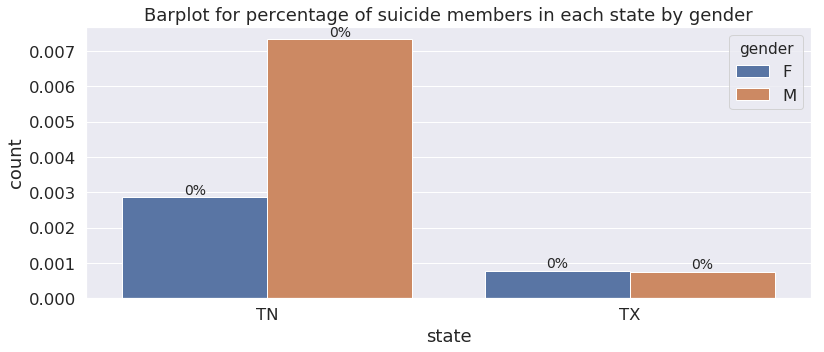

In [87]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = suicide_mems)
ax.set_title('Barplot for percentage of suicide members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.0001,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [88]:
mental_retard_mems = agg.groupby(['state', 'gender']).Mental_Retard_ind.mean().reset_index(name='count')
mental_retard_mems

state gender     count
0    TN      F  0.005714
1    TN      M  0.010073
2    TX      F  0.001949
3    TX      M  0.012772

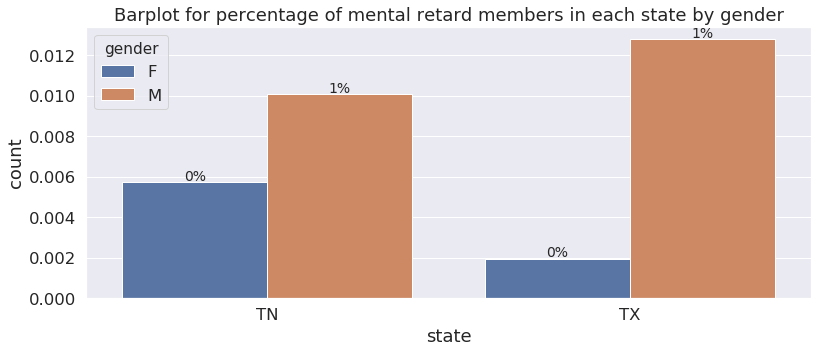

In [89]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = mental_retard_mems)
ax.set_title('Barplot for percentage of mental retard members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.0001,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [90]:
other_psych_mems = agg.groupby(['state', 'gender']).Other_Psych_ind.mean().reset_index(name='count')
other_psych_mems

state gender     count
0    TN      F  0.549048
1    TN      M  0.742674
2    TX      F  0.524756
3    TX      M  0.744553

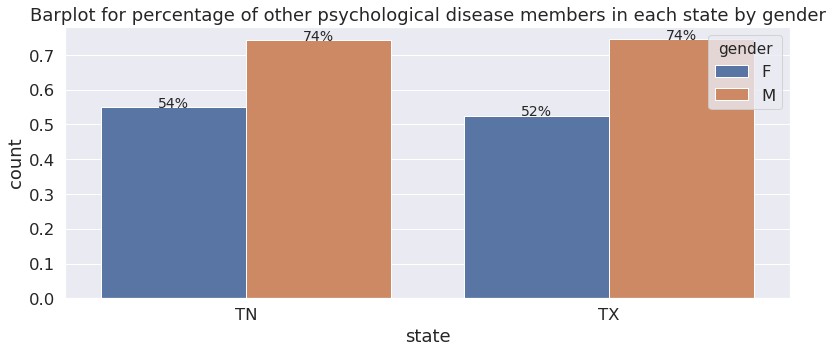

In [91]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='state', y = 'count', hue = 'gender', data = other_psych_mems)
ax.set_title('Barplot for percentage of other psychological disease members in each state by gender')
ax.set_xlabel('state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0,
           height+0.0005,
           str(int(height *100)) + '%',
           ha = 'center',
           size = 14)

In [92]:
dropComorCols = ["Obesity_ind", "ADHD_ind", "Personal_ind", "Suicide_ind", "Mental_Retard_ind"]
# members with the following conidtion is in low percentage:
# "Adjustment_ind",  "Dementia_ind", "Development_ind", "Schizophrenia_ind",

In [93]:
demoIndCols = ['gender_male',  'lang_english', 'state_TN', 'rural']

In [94]:
#### Cost cols 

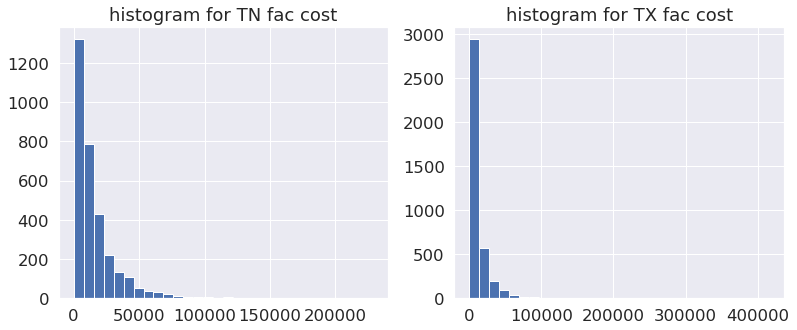

In [95]:
plt.figure(figsize = (13, 5))
states = agg.state.unique()
for i in range(len(states)):
    ax=plt.subplot(1,2,i+1)
    plt.hist(agg.loc[agg.state == states[i], 'fac_cost'], bins=30)
    plt.title('histogram for ' + states[i] + " fac cost")
plt.show()

In [96]:
state_fac_median = agg.groupby('state').fac_cost.median().reset_index(name='median')
state_fac_median


state     median
0    TN  10043.785
1    TX   5665.555

In [97]:
state_gender_fac_median = agg.groupby(['state', 'gender']).fac_cost.median().reset_index(name='median')
state_gender_fac_median

state gender     median
0    TN      F   9537.975
1    TN      M  10919.575
2    TX      F   4966.980
3    TX      M   6775.130

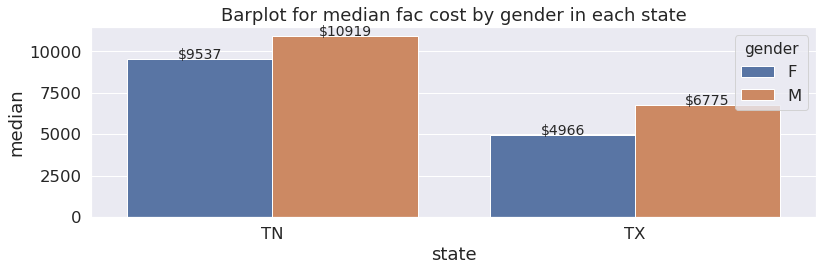

In [98]:
plt.figure(figsize=(13,3.5))
ax = sns.barplot(x='state',y='median',hue='gender', data=state_gender_fac_median)
ax.set_title('Barplot for median fac cost by gender in each state')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0, 
           height + 1, 
           '$' + str(int(height)),
           ha = 'center',
           size = 14)

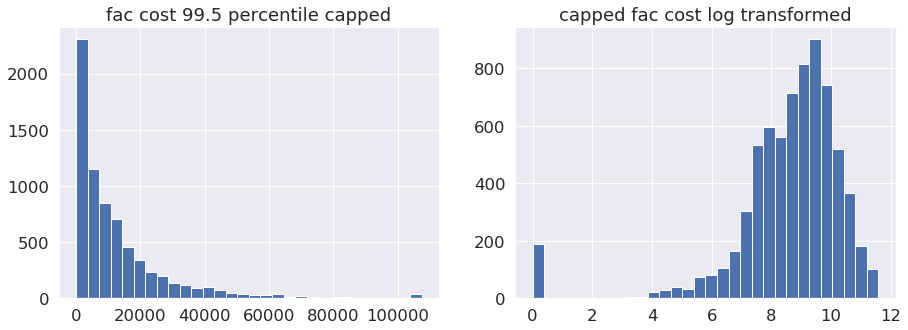

In [99]:
## fac 
## cap
facCost = pd.Series(np.where(agg.fac_cost > np.percentile(agg.fac_cost,99.5), np.percentile(agg.fac_cost,99.5), agg.fac_cost))
facCost.describe()
## log transform
facCostLog = np.log(facCost+1)
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
plt.hist(facCost, bins = 30)
plt.title('fac cost 99.5 percentile capped')
plt.subplot(1,2,2)
plt.hist(facCostLog, bins = 30)
plt.title('capped fac cost log transformed')
plt.show()



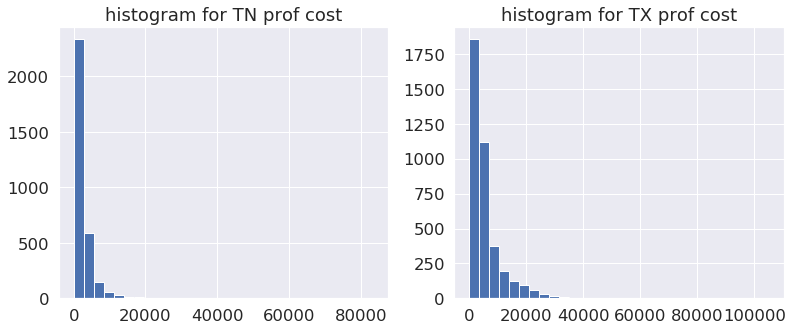

In [100]:
#### prof cost
plt.figure(figsize = (13, 5))
states = agg.state.unique()
for i in range(len(states)):
    ax=plt.subplot(1,2,i+1)
    plt.hist(agg.loc[agg.state == states[i], 'prof_cost'], bins=30)
    plt.title('histogram for ' + states[i] + " prof cost")
plt.show()

In [101]:
state_gender_prof_median = agg.groupby(['state', 'gender']).prof_cost.median().reset_index(name='median')
state_gender_prof_median

state gender    median
0    TN      F  1501.715
1    TN      M  1621.785
2    TX      F  3703.700
3    TX      M  3526.050

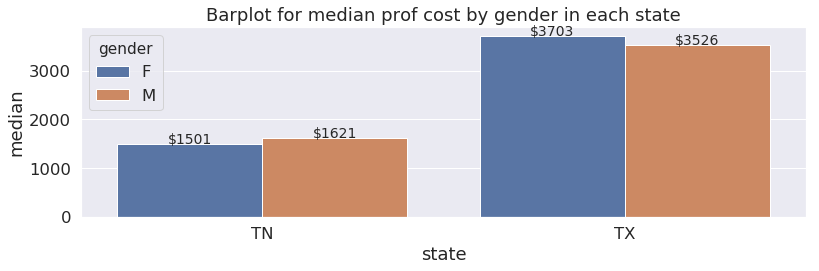

In [102]:
plt.figure(figsize=(13,3.5))
ax = sns.barplot(x='state',y='median',hue='gender', data=state_gender_prof_median)
ax.set_title('Barplot for median prof cost by gender in each state')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
           height+1,
           '$' + str(int(height)),
           ha='center',
           size=14)

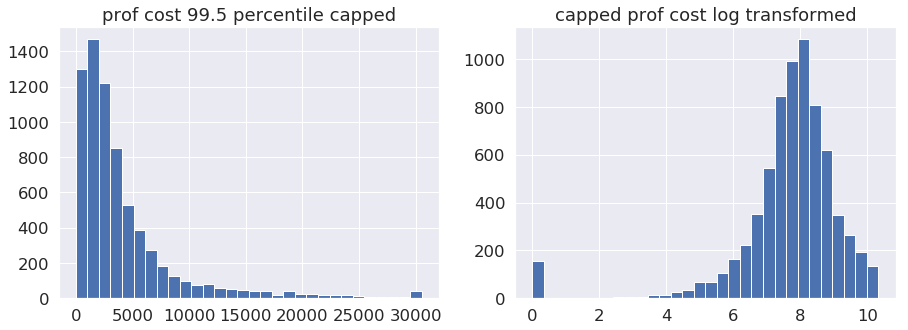

In [103]:
## prof
## cap
profCost = pd.Series(np.where(agg.prof_cost > np.percentile(agg.prof_cost,99.5), np.percentile(agg.prof_cost,99.5), agg.prof_cost))
profCost.describe()
## log transform
profCostLog = np.log(profCost+1)

plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
plt.hist(profCost, bins = 30)
plt.title('prof cost 99.5 percentile capped')
plt.subplot(1,2,2)
plt.hist(profCostLog, bins = 30)
plt.title('capped prof cost log transformed')
plt.show()



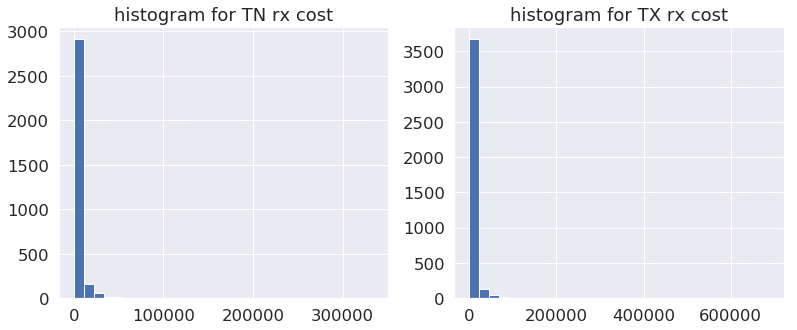

In [104]:
######## Rx cost

plt.figure(figsize = (13, 5))
states = agg.state.unique()
for i in range(len(states)):
    ax=plt.subplot(1,2,i+1)
    plt.hist(agg.loc[agg.state == states[i], 'rx_cost'], bins=30)
    plt.title('histogram for ' + states[i] + " rx cost")
plt.show()

In [105]:
state_gender_rx_median = agg.groupby(['state', 'gender']).rx_cost.median().reset_index(name='median')
state_gender_rx_median

state gender    median
0    TN      F  1318.435
1    TN      M   918.540
2    TX      F  1830.500
3    TX      M  1230.970

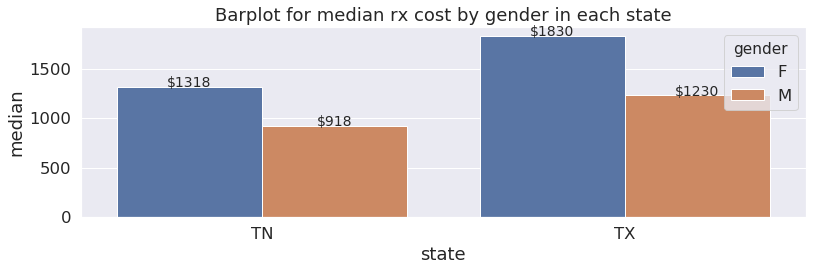

In [106]:
plt.figure(figsize=(13,3.5))
ax = sns.barplot(x='state',y='median',hue='gender', data=state_gender_rx_median)
ax.set_title('Barplot for median rx cost by gender in each state')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
           height+1,
           '$' + str(int(height)),
           ha='center',
           size=14)

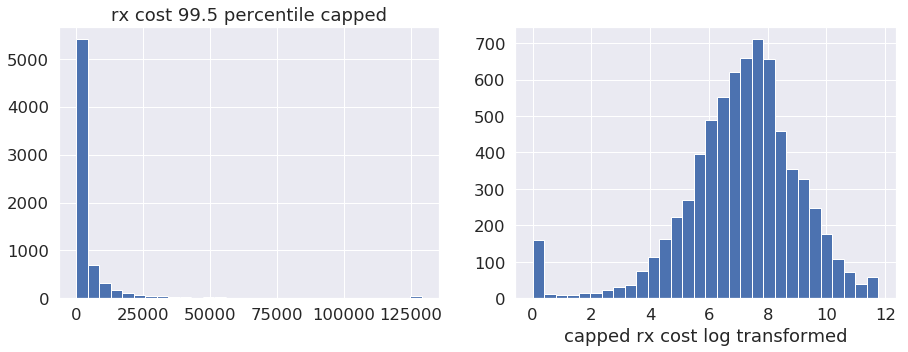

In [107]:
## Rx
## cap
rxCost = pd.Series(np.where(agg.rx_cost > np.percentile(agg.rx_cost,99.5), np.percentile(agg.rx_cost,99.5), agg.rx_cost))
rxCost.describe()
## log transform
rxCostLog = np.log(rxCost+1)

plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
plt.hist(rxCost, bins = 30)
plt.title('rx cost 99.5 percentile capped')
plt.subplot(1,2,2)
plt.hist(rxCostLog, bins = 30)
plt.xlabel('capped rx cost log transformed')
plt.show()


In [108]:
# standardScaler: Standardize features by removing the mean and scaling to unit variance
# The standard score of a sample x is calculated as: z = (x - u) / s


##  z transform
logCost = pd.concat([facCostLog, profCostLog, rxCostLog], axis=1)
logCost.columns = ['facLog', 'profLog', 'rxLog']
logCost.head()
stds = StandardScaler()
costTrans = stds.fit_transform(logCost)
costTrans = pd.DataFrame(costTrans)
costTrans.columns = ['facTrans', 'profTrans', 'rxTrans']
costTrans.describe()


facTrans     profTrans       rxTrans
count  7.088000e+03  7.088000e+03  7.088000e+03
mean   2.067571e-17  1.356452e-17 -3.196903e-17
std    1.000071e+00  1.000071e+00  1.000071e+00
min   -4.404488e+00 -4.790001e+00 -3.480180e+00
25%   -3.764594e-01 -2.793566e-01 -4.954349e-01
50%    1.804811e-01  1.388842e-01  8.982262e-02
75%    5.909252e-01  5.312857e-01  5.951451e-01
max    1.552970e+00  1.663966e+00  2.307381e+00

In [109]:
agg2 = pd.concat([agg, costTrans],axis=1)
agg2.shape



(7088, 99)

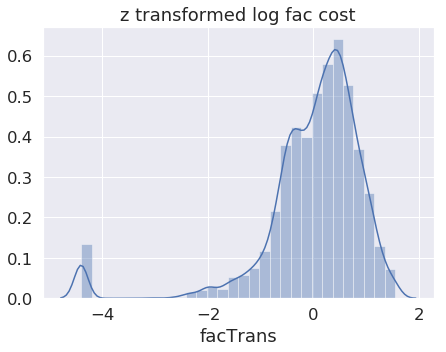

In [110]:
plt.figure(figsize = (7,5))
#ax = sns.distplot(agg2.facTrans.dropna(), bins = 30)
ax = sns.distplot(agg2.facTrans, bins = 30)
plt.title('z transformed log fac cost')
plt.show()


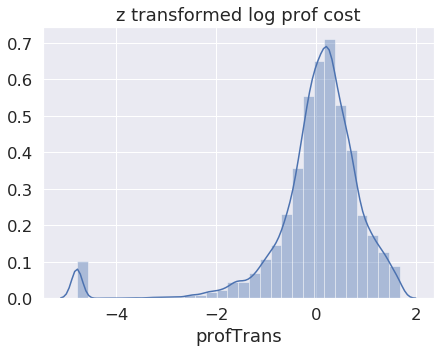

In [111]:
plt.figure(figsize = (7,5))
#ax = sns.distplot(agg2.profTrans.dropna(), bins = 30)
ax = sns.distplot(agg2.profTrans, bins = 30)
plt.title('z transformed log prof cost')
plt.show()


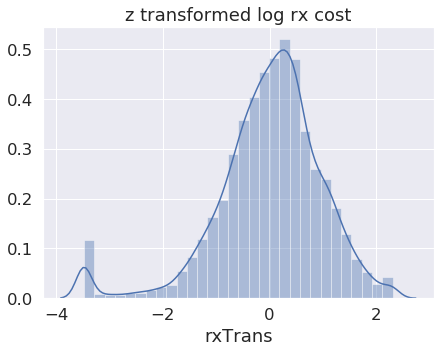

In [112]:
plt.figure(figsize = (7,5))
#ax = sns.distplot(agg2.rxTrans.dropna(), bins = 30)
ax = sns.distplot(agg2.rxTrans, bins = 30)
plt.title('z transformed log rx cost')
plt.show()


# mu, sigma = stats.norm.fit(facCostLog) #mean, std
# n, bins, patches = plt.hist(profCostLog, bins = 30)
# y = stats.norm.pdf(bins, mu, sigma)
# plt.plot(bins, y, 'r--', linewidth = 2)


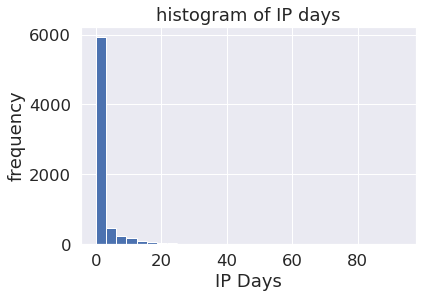

In [113]:
plt.hist(agg2.ip_days, bins = 30)
plt.xlabel('IP Days')
plt.ylabel('frequency')
plt.title('histogram of IP days')
plt.show()

In [114]:
print((agg2.ip_days == 0).mean())  # 40.64% no ip days
agg2.ip_days.describe()  # 0 - 93

0.40646162528216706


count    7088.000000
mean        2.370626
std         5.276085
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        93.000000
Name: ip_days, dtype: float64

In [115]:
print("25 percentile of IP: " + str(np.percentile(agg2.ip_days, 25)))
print("50 percentile of IP: " + str(np.percentile(agg2.ip_days, 50)))
print("75 percentile of IP: " + str(np.percentile(agg2.ip_days, 75)))
print("80 percentile of IP: " + str(np.percentile(agg2.ip_days, 80)))
print("85 percentile of IP: " + str(np.percentile(agg2.ip_days, 85)))
print("90 percentile of IP: " + str(np.percentile(agg2.ip_days, 90)))
print("95 percentile of IP: " + str(np.percentile(agg2.ip_days, 95)))
print("99 percentile of IP: " + str(np.percentile(agg2.ip_days, 99)))

# no ip
# >0 & <= 75 percentile
# > 75 percentile

25 percentile of IP: 0.0
50 percentile of IP: 1.0
75 percentile of IP: 2.0
80 percentile of IP: 3.0
85 percentile of IP: 4.0
90 percentile of IP: 6.0
95 percentile of IP: 11.0
99 percentile of IP: 24.0


In [116]:
agg2['ipNone'] = np.where(agg2.ip_days == 0, 1, 0)
agg2.ipNone.value_counts()

0    4207
1    2881
Name: ipNone, dtype: int64

In [117]:
ipP75 = np.percentile(agg2.ip_days, 75)
print(ipP75)
ipLow = (agg2.ip_days >0) & (agg2.ip_days <= ipP75)
agg2['ipLow'] = np.where(ipLow, 1, 0)
agg2.ipLow.value_counts()

2.0


0    4375
1    2713
Name: ipLow, dtype: int64

In [118]:
print(sum(agg2.ip_days > ipP75))
2881 + 2713 + 1494 

1494


7088

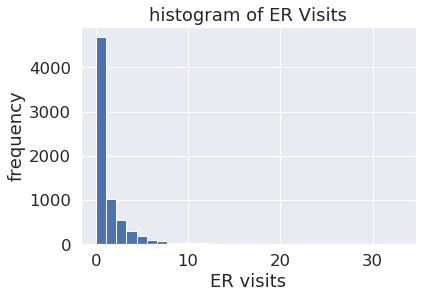

In [119]:
plt.hist(agg.er_visits, bins = 30)
plt.xlabel('ER visits')
plt.ylabel('frequency')
plt.title('histogram of ER Visits')
plt.show()

In [120]:
print((agg2.er_visits == 0).mean()) # 40.39% no er visits
agg2.er_visits.describe()  # 0 - 33

0.40392212189616256


count    7088.000000
mean        1.522432
std         2.355472
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        33.000000
Name: er_visits, dtype: float64

In [121]:
print("25 percentile of ER: " + str(np.percentile(agg2.er_visits, 25)))
print("50 percentile of ER: " + str(np.percentile(agg2.er_visits, 50)))
print("75 percentile of ER: " + str(np.percentile(agg2.er_visits, 75)))
print("80 percentile of ER: " + str(np.percentile(agg2.er_visits, 80)))
print("85 percentile of ER: " + str(np.percentile(agg2.er_visits, 85)))
print("90 percentile of ER: " + str(np.percentile(agg2.er_visits, 90)))
print("95 percentile of ER: " + str(np.percentile(agg2.er_visits, 95)))
print("99 percentile of ER: " + str(np.percentile(agg2.er_visits, 99)))

# no ER
# >0 & <= 75 percentile
# > 75 percentile

25 percentile of ER: 0.0
50 percentile of ER: 1.0
75 percentile of ER: 2.0
80 percentile of ER: 2.0
85 percentile of ER: 3.0
90 percentile of ER: 4.0
95 percentile of ER: 5.0
99 percentile of ER: 11.0


In [122]:
agg2['erNone'] = np.where(agg2.er_visits == 0, 1, 0)
agg2.erNone.value_counts()

0    4225
1    2863
Name: erNone, dtype: int64

In [123]:
erP75 = np.percentile(agg2.er_visits, 75)
print(erP75)
erLow = (agg2.er_visits > 0) & (agg2.er_visits <= erP75)
agg2['erLow'] = np.where(erLow, 1, 0)
agg2.erLow.value_counts()

2.0


0    4237
1    2851
Name: erLow, dtype: int64

In [124]:
sum(agg2.er_visits > erP75)
2863+2851+1374

7088

In [125]:
## features 

In [126]:
## comorbidity columns
comorCols = [x for x in comorIndCols if x not in dropComorCols]

In [127]:
## demographic columns 
ageCols = ['ageLt65', 'age65to75']
demographicCols = demoIndCols + ageCols

In [128]:
## cost columns
costCols = ['facTrans', 'profTrans', 'rxTrans']

In [129]:
## utility columns
utilCols = ['ipNone', 'ipLow', 'erNone', 'erLow']

In [130]:
allCols = comorCols + demographicCols + costCols + utilCols
len(allCols)  #35

35

In [131]:
## fit the model with demographic data only

demo_data = agg2[demographicCols]
demo_data.head()

gender_male  lang_english  state_TN  rural  ageLt65  age65to75
0            0             1         1      1        0          1
1            0             1         0      0        0          1
2            0             1         0      0        0          1
3            1             1         0      0        1          0
4            0             1         0      1        1          0

In [132]:
sum_of_squared_distances = []
K = range(1,35)
for k in K:
    km = KMeans(n_clusters = k, random_state =42)
    km = km.fit(demo_data)
    sum_of_squared_distances.append(km.inertia_)


Text(0.5,1,'Elbow Method For Optimal k (demographic)')

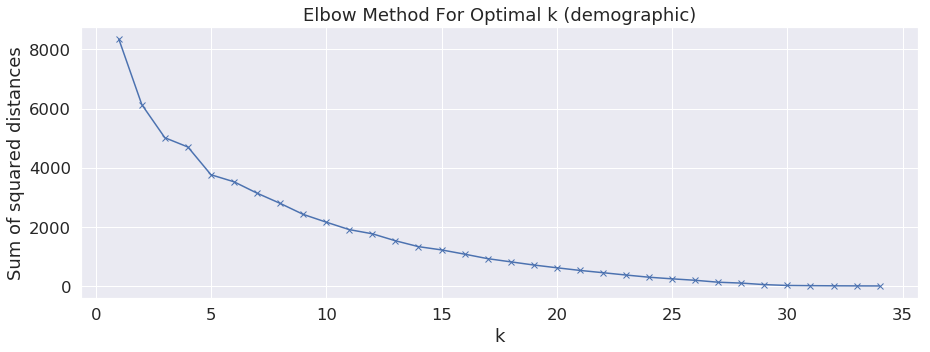

In [133]:
plt.figure(figsize=(15,5))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances') # of samples to the nearest centroid
plt.title('Elbow Method For Optimal k (demographic)')

In [134]:
# kmeans5 = KMeans(n_clusters =5, random_state =42)
# kmeans5.fit(demo_data)

In [135]:
# y_km = kmeans5.fit_predict(demo_data)
# y = np.bincount(y_km)
# ii = np.nonzero(y)[0]
# zip(ii, y[ii])

In [136]:
# kmeans30 = KMeans(n_clusters = 30, random_state=42)
# kmeans30.fit(demo_data)

In [137]:
# y_km = kmeans30.fit_predict(demo_data)
# y=np.bincount(y_km)
# ii = np.nonzero(y)[0]
# zip(ii, y[ii])

In [138]:
## fit the model with comorbidity data only

comor_data = agg2[comorCols]
comor_data.head()

SUD_ind  Anxiety_ind  Depression_ind  Asthma_ind  CHF_ind  CAD_ind  \
0        0            1               1           0        0        1   
1        1            0               1           0        0        1   
2        0            1               1           0        0        0   
3        1            1               1           0        0        0   
4        0            1               0           0        0        0   

   COPD_ind  Diabetes_ind  Pneumonia_ind  Gallbladder_ind  ...  Arthritis_ind  \
0         1             0              0                0  ...              0   
1         1             1              1                0  ...              0   
2         0             0              0                0  ...              1   
3         0             0              0                0  ...              0   
4         0             0              0                0  ...              0   

   Chro_Pain_ind  Smoking_ind  Bipolar_ind  Hypertension_ind  Adjustment_ind  \
0              0            0            0                 1               0   
1              1            0            0                 1               0   
2              0            0            1                 1               0   
3              1            0            0                 0               0   
4              0            0            1                 0               0   

   Dementia_ind  Development_ind  Schizophrenia_ind  Other_Psych_ind  
0             0                0                  0                1  
1             0                0                  0                1  
2             0                0                  0                1  
3             0                0                  0                1  
4             0                0                  0                1  

[5 rows x 22 columns]

In [139]:
sum_of_squared_distances = []
K = range(1, 50)
for k in K:
    km = KMeans(n_clusters = k, random_state =42)
    km = km.fit(comor_data)
    sum_of_squared_distances.append(km.inertia_)

Text(0.5,1,'Elbow Method for Optimal K (Comorbidity)')

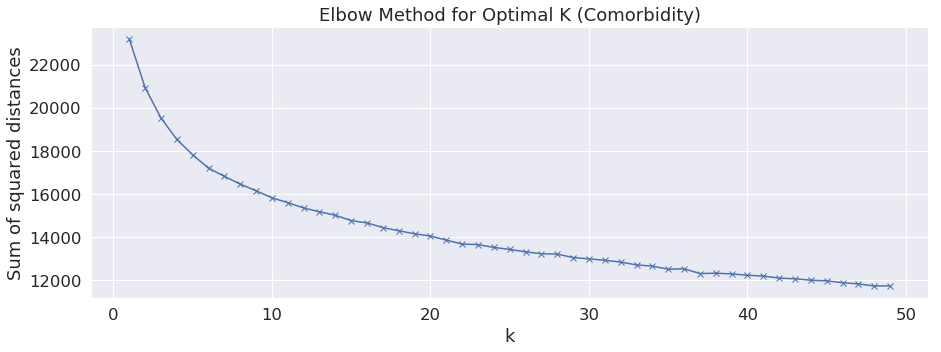

In [140]:
plt.figure(figsize = (15, 5))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal K (Comorbidity)')

In [141]:
# kmeans6 = KMeans(n_clusters = 6, random_state =42)
# kmeans6.fit(comor_data)

In [142]:
# y_km = kmeans6.fit_predict(comor_data)
# y = np.bincount(y_km)
# ii = np.nonzero(y)[0]
# zip(ii, y[ii])

In [143]:
## fit the model with cost data only
cost_data = agg2[costCols]
cost_data.head()

facTrans  profTrans   rxTrans
0  0.102292  -0.277667 -1.506401
1  1.226498   0.801915  0.644858
2 -4.404488   0.354029 -1.022623
3 -0.103883   0.177168  0.108863
4  0.488775   0.519856 -0.193738

In [144]:
sum_of_squared_distances=[]
K = range(1,50)
for k in K:
    km =  KMeans(n_clusters = k, random_state = 42)
    km = km.fit(cost_data)
    sum_of_squared_distances.append(km.inertia_)

Text(0.5,1,'Elbow Method for Optimal k (cost)')

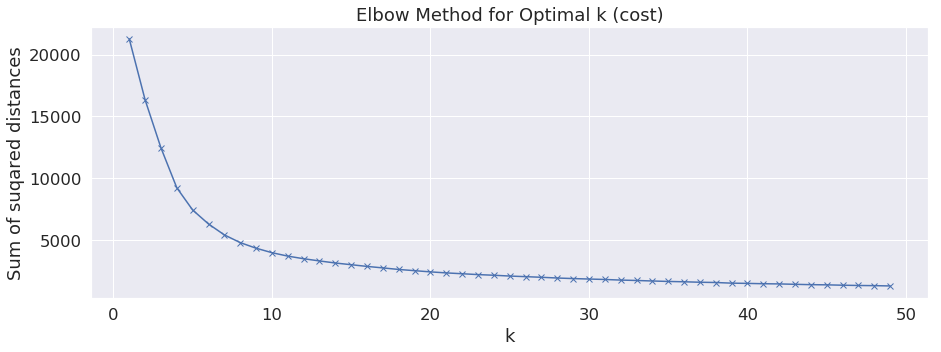

In [145]:
plt.figure(figsize = (15,5))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of suqared distances')
plt.title('Elbow Method for Optimal k (cost)')

In [146]:
### fit the model with utility data only
util_data = agg2[utilCols]
util_data.head()

ipNone  ipLow  erNone  erLow
0       0      1       1      0
1       0      0       0      0
2       1      0       1      0
3       1      0       0      0
4       0      1       0      1

In [147]:
sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters = k, random_state = 42)
    km = km.fit(util_data)
    sum_of_squared_distances.append(km.inertia_)

Text(0.5,1,'Elbow Method for Optimal K (utility)')

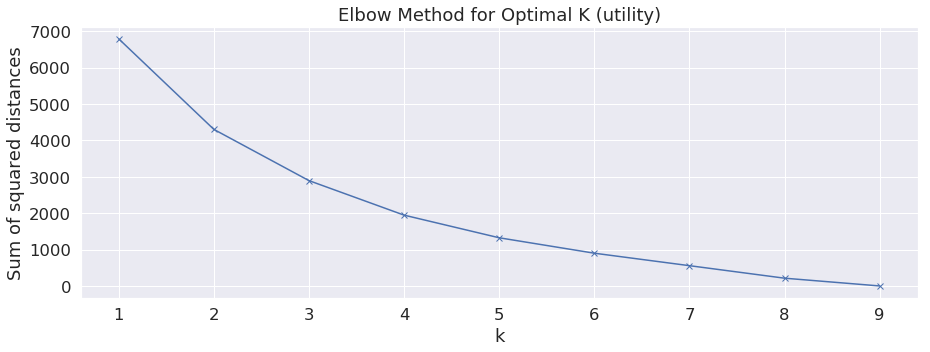

In [148]:
plt.figure(figsize = (15,5))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal K (utility)')

In [149]:
## fit the model with demographic and cost features
demo_cost_data = agg2[demographicCols + costCols]
demo_cost_data.head()

gender_male  lang_english  state_TN  rural  ageLt65  age65to75  facTrans  \
0            0             1         1      1        0          1  0.102292   
1            0             1         0      0        0          1  1.226498   
2            0             1         0      0        0          1 -4.404488   
3            1             1         0      0        1          0 -0.103883   
4            0             1         0      1        1          0  0.488775   

   profTrans   rxTrans  
0  -0.277667 -1.506401  
1   0.801915  0.644858  
2   0.354029 -1.022623  
3   0.177168  0.108863  
4   0.519856 -0.193738

In [150]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters = k, random_state = 42)
    km = km.fit(demo_cost_data)
    sum_of_squared_distances.append(km.inertia_)

Text(0.5,1,'Elbow Method for Optimal k (demographic + cost)')

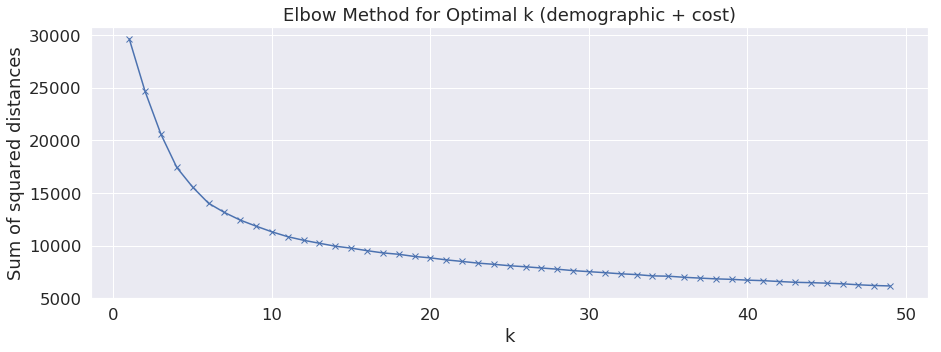

In [151]:
plt.figure(figsize = (15, 5))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k (demographic + cost)')

In [152]:
## fit the model with comorbidity and cost features 

comor_cost_data = agg2[comorCols + costCols]
comor_cost_data.head()

SUD_ind  Anxiety_ind  Depression_ind  Asthma_ind  CHF_ind  CAD_ind  \
0        0            1               1           0        0        1   
1        1            0               1           0        0        1   
2        0            1               1           0        0        0   
3        1            1               1           0        0        0   
4        0            1               0           0        0        0   

   COPD_ind  Diabetes_ind  Pneumonia_ind  Gallbladder_ind  ...  Bipolar_ind  \
0         1             0              0                0  ...            0   
1         1             1              1                0  ...            0   
2         0             0              0                0  ...            1   
3         0             0              0                0  ...            0   
4         0             0              0                0  ...            1   

   Hypertension_ind  Adjustment_ind  Dementia_ind  Development_ind  \
0                 1               0             0                0   
1                 1               0             0                0   
2                 1               0             0                0   
3                 0               0             0                0   
4                 0               0             0                0   

   Schizophrenia_ind  Other_Psych_ind  facTrans  profTrans   rxTrans  
0                  0                1  0.102292  -0.277667 -1.506401  
1                  0                1  1.226498   0.801915  0.644858  
2                  0                1 -4.404488   0.354029 -1.022623  
3                  0                1 -0.103883   0.177168  0.108863  
4                  0                1  0.488775   0.519856 -0.193738  

[5 rows x 25 columns]

In [153]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters = k, random_state = 42)
    km = km.fit(comor_cost_data)
    sum_of_squared_distances.append(km.inertia_)

Text(0.5,1,'Elbow Method for Optimal k (comorbidity + cost)')

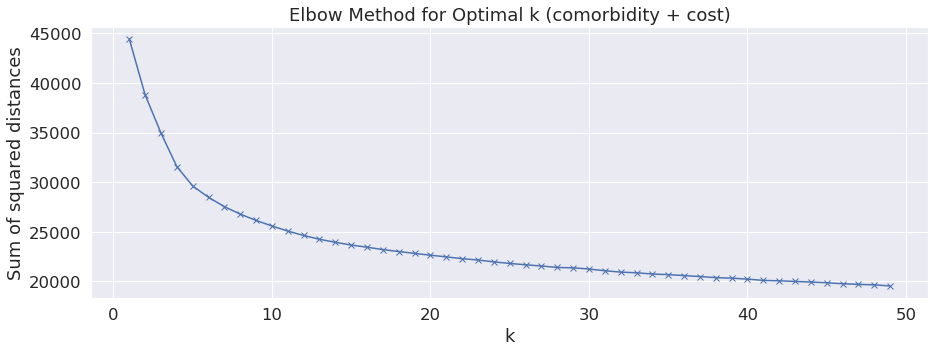

In [154]:
plt.figure(figsize = (15, 5))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k (comorbidity + cost)')

In [155]:
## fit the model with demographic, comorbidity and cost features 

demo_comor_cost_data = agg2[demographicCols + comorCols + costCols]
demo_comor_cost_data.head()

gender_male  lang_english  state_TN  rural  ageLt65  age65to75  SUD_ind  \
0            0             1         1      1        0          1        0   
1            0             1         0      0        0          1        1   
2            0             1         0      0        0          1        0   
3            1             1         0      0        1          0        1   
4            0             1         0      1        1          0        0   

   Anxiety_ind  Depression_ind  Asthma_ind  ...  Bipolar_ind  \
0            1               1           0  ...            0   
1            0               1           0  ...            0   
2            1               1           0  ...            1   
3            1               1           0  ...            0   
4            1               0           0  ...            1   

   Hypertension_ind  Adjustment_ind  Dementia_ind  Development_ind  \
0                 1               0             0                0   
1                 1               0             0                0   
2                 1               0             0                0   
3                 0               0             0                0   
4                 0               0             0                0   

   Schizophrenia_ind  Other_Psych_ind  facTrans  profTrans   rxTrans  
0                  0                1  0.102292  -0.277667 -1.506401  
1                  0                1  1.226498   0.801915  0.644858  
2                  0                1 -4.404488   0.354029 -1.022623  
3                  0                1 -0.103883   0.177168  0.108863  
4                  0                1  0.488775   0.519856 -0.193738  

[5 rows x 31 columns]

In [156]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters = k, random_state = 42)
    km = km.fit(demo_comor_cost_data)
    sum_of_squared_distances.append(km.inertia_)

Text(0.5,1,'Elbow Method for Optimal k (demographic + comorbidity + cost)')

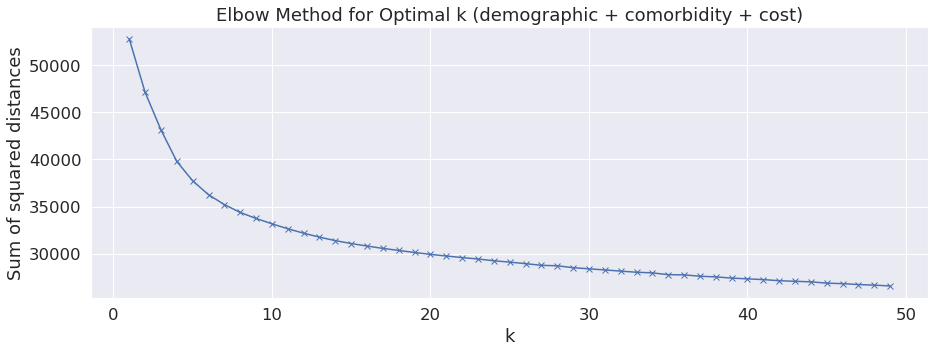

In [157]:
plt.figure(figsize = (15, 5))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k (demographic + comorbidity + cost)')

In [158]:
## fit the model with demographic, comorbidity, cost and utility features 

allCols = demographicCols + comorCols + costCols + utilCols

all_data = agg2[allCols]
all_data.head()

gender_male  lang_english  state_TN  rural  ageLt65  age65to75  SUD_ind  \
0            0             1         1      1        0          1        0   
1            0             1         0      0        0          1        1   
2            0             1         0      0        0          1        0   
3            1             1         0      0        1          0        1   
4            0             1         0      1        1          0        0   

   Anxiety_ind  Depression_ind  Asthma_ind  ...  Development_ind  \
0            1               1           0  ...                0   
1            0               1           0  ...                0   
2            1               1           0  ...                0   
3            1               1           0  ...                0   
4            1               0           0  ...                0   

   Schizophrenia_ind  Other_Psych_ind  facTrans  profTrans   rxTrans  ipNone  \
0                  0                1  0.102292  -0.277667 -1.506401       0   
1                  0                1  1.226498   0.801915  0.644858       0   
2                  0                1 -4.404488   0.354029 -1.022623       1   
3                  0                1 -0.103883   0.177168  0.108863       1   
4                  0                1  0.488775   0.519856 -0.193738       0   

   ipLow  erNone  erLow  
0      1       1      0  
1      0       0      0  
2      0       1      0  
3      0       0      0  
4      1       0      1  

[5 rows x 35 columns]

In [159]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters = k, random_state = 42)
    km = km.fit(all_data)
    sum_of_squared_distances.append(km.inertia_)

Text(0.5,1,'Elbow Method for Optimal k (demographic + comorbidity + cost + utility)')

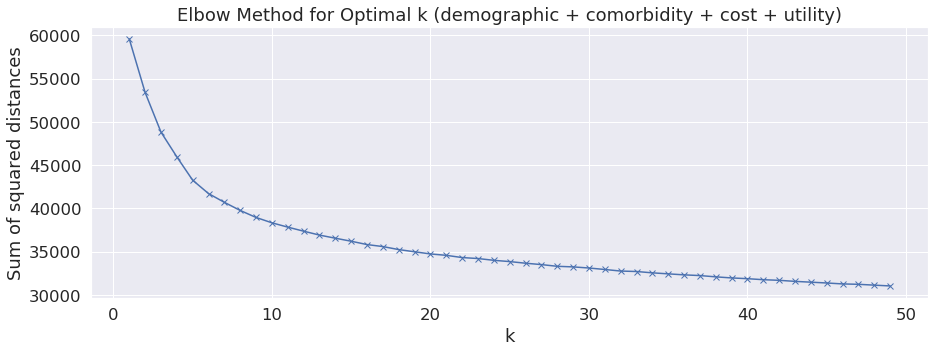

In [160]:
plt.figure(figsize = (15, 5))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k (demographic + comorbidity + cost + utility)')

In [161]:
# The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to 
# other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the 
# object is well matched to its own cluster and poorly matched to neighboring clusters.

from sklearn.metrics import silhouette_score
K = range(2,50)
avg_silhouette_list = []
for i in K:
    cluster = KMeans(n_clusters = i, random_state=42)
    cluster = cluster.fit(all_data)
    cluster_labels = cluster.fit_predict(all_data)
    silhouette_avg = silhouette_score(all_data, cluster_labels)
    avg_silhouette_list.append(silhouette_avg)
    print('for n_cluster = ' + str(i) + ' the silhouette score is '+ str(silhouette_avg))


for n_cluster = 2 the silhouette score is 0.0982223878071198
for n_cluster = 3 the silhouette score is 0.10582573561783881
for n_cluster = 4 the silhouette score is 0.1031149502440724
for n_cluster = 5 the silhouette score is 0.10405889036886126
for n_cluster = 6 the silhouette score is 0.09262894956733418
for n_cluster = 7 the silhouette score is 0.07845849328713447
for n_cluster = 8 the silhouette score is 0.07623855001209924
for n_cluster = 9 the silhouette score is 0.07608398837025333
for n_cluster = 10 the silhouette score is 0.07488335340123044
for n_cluster = 11 the silhouette score is 0.07257344257564798
for n_cluster = 12 the silhouette score is 0.07113193033890985
for n_cluster = 13 the silhouette score is 0.06641946052247025
for n_cluster = 14 the silhouette score is 0.06958587971444523
for n_cluster = 15 the silhouette score is 0.07002933820853582
for n_cluster = 16 the silhouette score is 0.06427782188334247
for n_cluster = 17 the silhouette score is 0.06151528543923895
fo

In [162]:
silhouette_df = pd.DataFrame({'number_of_clusters' : K, 'avg_silhouette_score': avg_silhouette_list})

Text(0,0.5,'average silhouette score')

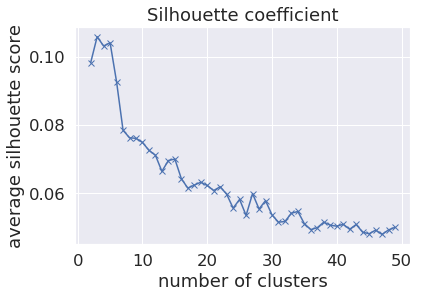

In [163]:
plt.plot(silhouette_df.number_of_clusters, silhouette_df.avg_silhouette_score, 'bx-')
plt.title('Silhouette coefficient')
plt.xlabel('number of clusters')
plt.ylabel('average silhouette score')

In [164]:
### gap statistic

In [165]:
original_dummy_cols = ['gender_male', 'lang_english', 'state_TN', 'rural', 'SUD_ind', 'Anxiety_ind', 
                       'Depression_ind', 'Asthma_ind', 'CHF_ind', 'CAD_ind', 'COPD_ind', 'Diabetes_ind', 
                       'Pneumonia_ind', 'Gallbladder_ind', 'Inju_Pois_ind', 'External_ind', 'Arthritis_ind', 
                       'Chro_Pain_ind', 'Smoking_ind', 'Bipolar_ind', 'Hypertension_ind', 'Adjustment_ind', 
                       'Dementia_ind', 'Development_ind', 'Schizophrenia_ind', 'Other_Psych_ind']
original_num_cols = ['age', 'fac_cost', 'prof_cost', 'rx_cost', 'ip_days', 'er_visits']
original_cols = original_dummy_cols + original_num_cols


In [166]:

validation_data = agg[original_cols]   
validation_data.shape 

(7088, 32)

In [511]:
for_clinical_cols = ['member_id', 'p12m_days', 'dob', 'age',
       'eff_date', 'term_date', 'gender', 'gender_male', 'language', 'lang_english', 'ProductType', 
       'OperationalMarket', 'relToSubs', 'sourceDesc', 'state', 'state_TN', 'zip', 'rural',
       'medical_exclusion_status', 'fac_cost', 'prof_cost',
       'rx_cost', 'total_cost', 'fac_claim_count', 'prof_claim_count',
       'rx_claim_count', 'ndc_count', 'ip_admits', 'ip_days', 'avg_los',
       'last_ip_discharge', 'er_visits', 'last_hosp_treatment_type',
       'last_hosp_treatment_date', 'last_hosp_DX1_description',
       'p10_imp_cost', 'SUD_cnt', 'Anxiety_cnt', 'Depression_cnt',
       'Asthma_cnt', 'CHF_cnt', 'CAD_cnt', 'COPD_cnt', 'Diabetes_cnt',
       'Pneumonia_cnt', 'Gallbladder_cnt', 'Inju_Pois_cnt', 'External_cnt',
       'Arthritis_cnt', 'Chro_Pain_cnt', 'Smoking_cnt', 'Obesity_cnt',
       'Bipolar_cnt', 'Hypertension_cnt', 'Adjustment_cnt', 'ADHD_cnt',
       'Dementia_cnt', 'Development_cnt', 'Personal_cnt',
       'Schizophrenia_cnt', 'Suicide_cnt', 'Mental_Retard_cnt',
       'Other_Psych_cnt', 'SUD_ind', 'Anxiety_ind', 'Depression_ind',
       'Asthma_ind', 'CHF_ind', 'CAD_ind', 'COPD_ind', 'Diabetes_ind',
       'Pneumonia_ind', 'Gallbladder_ind', 'Inju_Pois_ind', 'External_ind',
       'Arthritis_ind', 'Chro_Pain_ind', 'Smoking_ind', 'Obesity_ind',
       'Bipolar_ind', 'Hypertension_ind', 'Adjustment_ind', 'ADHD_ind',
       'Dementia_ind', 'Development_ind', 'Personal_ind',
       'Schizophrenia_ind', 'Suicide_ind', 'Mental_Retard_ind',
       'Other_Psych_ind']
for_clinical = agg[for_clinical_cols]

In [556]:
for_clinical.head()

member_id  p12m_days         dob  age    eff_date   term_date gender  \
0  780460293*01        365  1944-12-06   74  2019-01-01  2999-12-31      F   
1      35755536        365  1952-04-04   66  2019-01-01  2999-12-31      F   
2  774979747*01        365  1944-03-09   74  2019-01-01  2019-01-31      F   
3  774161186*01        365  1968-03-06   50  2019-01-01  2999-12-31      M   
4  781029415*01        365  1964-09-14   54  2019-01-01  2999-12-31      F   

   gender_male language  lang_english  ... Development_ind Personal_ind  \
0            0  ENGLISH             1  ...               0            0   
1            0  ENGLISH             1  ...               0            0   
2            0  ENGLISH             1  ...               0            0   
3            1  ENGLISH             1  ...               0            0   
4            0  ENGLISH             1  ...               0            0   

  Schizophrenia_ind Suicide_ind Mental_Retard_ind  Other_Psych_ind  cluster10  \
0                 0           0                 0                1          3   
1                 0           0                 0                1          2   
2                 0           0                 0                1          1   
3                 0           0                 0                1          5   
4                 0           0                 0                1          3   

   cluster15 cluster20  cluster6  
0         15        17         6  
1         11         1         1  
2          7         5         3  
3         12        10         5  
4          1         6         2  

[5 rows x 94 columns]

In [558]:
for_clinical.cluster6.value_counts().sort_index()

1    1978
2    1944
3     235
4     191
5    2169
6     571
Name: cluster6, dtype: int64

In [574]:
print(for_clinical.shape)

enrolled = pd.read_csv("enrolled_member_ids.txt", header = 0, sep="|", dtype =object)

enrolled_data = for_clinical[for_clinical['member_id'].isin(enrolled.x.to_list())]


enrolled_data.shape

# import xlsxwriter
# writer = pd.ExcelWriter('enrolled_member_data_with_cluster_labels.xlsx', engine='xlsxwriter')

# # Convert the dataframe to an XlsxWriter Excel object.
# enrolled_data.to_excel(writer, sheet_name='Sheet1')

# # Close the Pandas Excel writer and output the Excel file.
# writer.save()

(7088, 94)


In [ ]:
#######   regularization 

In [ ]:
######## test for BIC implementation

# https://en.wikipedia.org/wiki/Bayesian_information_criterion
# BIC = ln(n)*k - 2ln(L)
# n: number of samples/data points, here it's N; 
# k: the number of parameters estimated by the model, here it's the sum of
# (1) m - 1 class probabilities (number of clusters)
# (2) d * m centroid coordinates (d: number of features)
# (3) 1 variance estimate
# so k on the formula equals m*(d+1)

# ln(L): log likelihood of the data in the m-mean model
# RSS: sum of squared distances for kmeans, kmeans.inertia_;
# estimate of the variance of the error: sigma_square_hat = RSS/(N-m) = kmeans.inertia_/(N-m)
# assume gausian distribution, the posterior probability for cluster i is 
# p[i] = n[i]/N * 1/(sqrt(2*pi)*sigma_square**d) * exp(-1/2*sigma_square * (x[i]-mean[i])**2)
# ln(L) = log (P[1]*P[2]* ....)

# focusing just on the set of points which belong to centroid n 
# and plugging in the maximum likelihood estimates yields:
# ln(L[i]) = -n[i]/2*ln(2*pi) - n[i]*d*ln(sigma_square) - (n[i] - m)/2 + n[i]ln(n[i]) - n[i]ln(N) 

## BIC = ln(N)*m*(d+1) -2*sum(ln(L[i])) 


In [319]:
# m = kmeans10.n_clusters
# N, d = all_data.shape #7088, 35
# labels = kmeans10.labels_
# n = np.bincount(labels)

In [322]:
# # compute variance for all clusters
# cl_var = kmeans10.inertia_/(N-m)
# const_term = np.log(N)*m*(d+1)

In [324]:
# BIC = const_term - 2*sum(-n[i]/2*np.log(2*np.pi) - n[i]*d*np.log(cl_var) - (n[i]-m)/2 + n[i]*np.log(n[i]) -n[i]*np.log(N) for i in range(m))

In [450]:
def bic_score(km, dat):
    m = km.n_clusters
    N, d = dat.shape
    labels = km.labels_
    n = np.bincount(labels)
    cl_var = km.inertia_/(N-m)
    const_term = np.log(N)*m*(d+1)
    BIC = const_term - 2*sum(-n[i]/2*np.log(2*np.pi) - n[i]*d*np.log(cl_var) - (n[i]-m)/2 + n[i]*np.log(n[i]) -n[i]*np.log(N) for i in range(m))
    return BIC    

In [451]:
bic_list = []
K = range(1,51)
for k in K:
    km = KMeans(n_clusters = k, random_state = 42)
    km = km.fit(all_data)
    bic = bic_score(km, all_data)
    bic_list.append(bic)

Text(0.5,1,'BIC score vs K, equal variance')

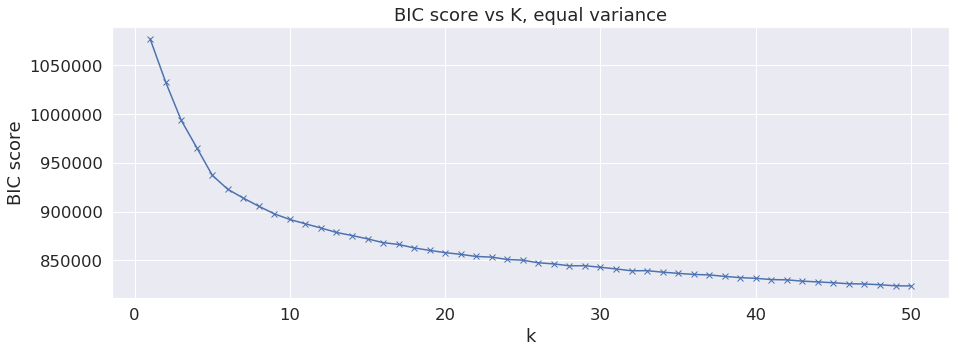

In [452]:
plt.figure(figsize = (15, 5))
plt.plot(K, bic_list, 'bx-')
plt.xlabel('k')
plt.ylabel('BIC score')
plt.title('BIC score vs K, equal variance')

In [453]:
## k = m - 1 + m*d*(d+1)/2 
def bic_score2(km, dat):
    m = km.n_clusters
    N, d = dat.shape
    labels = km.labels_
    n = np.bincount(labels)
    cl_var = km.inertia_/(N-m)
    const_term = np.log(N)*(m - 1 + m*d*(d+1)/2)  
    BIC = const_term - 2*sum(-n[i]/2*np.log(2*np.pi) - n[i]*d*np.log(cl_var) - (n[i]-m)/2 + n[i]*np.log(n[i]) -n[i]*np.log(N) for i in range(m))
    return BIC    

In [454]:
bic_list2 = []
K = range(1,31)
for k in K:
    km = KMeans(n_clusters = k, random_state = 42)
    km = km.fit(all_data)
    bic = bic_score2(km, all_data)
    bic_list2.append(bic)

Text(0.5,1,'Modified BIC score vs K: dof = C - 1 + C*d*(d+1)/2')

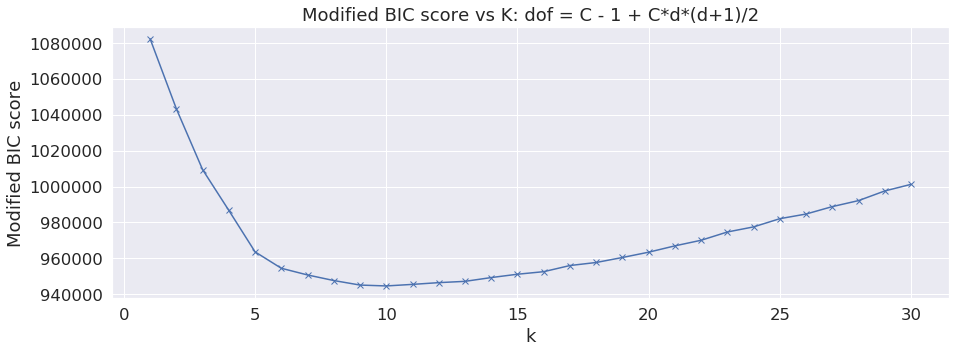

In [455]:
plt.figure(figsize = (15, 5))
plt.plot(K, bic_list2, 'bx-')
plt.xlabel('k')
plt.ylabel('Modified BIC score')
plt.title('Modified BIC score vs K: dof = C - 1 + C*d*(d+1)/2')

## try 8 -13 clusters

In [456]:
## different covariance matrix in each clustesr, k = m - 1 + m*d*(d+1)/2 

from scipy.spatial import distance

def bic_score3(km, dat):
    m = km.n_clusters
    N, d = dat.shape
    labels = km.labels_
    centers = km.cluster_centers_
    n = np.bincount(labels)
    cl_var = [(1.0 / (n[i] - m)) * sum(distance.cdist(dat[labels== i], np.reshape(centers[i], (1,-1)), 'euclidean')**2) for i in range(m)]
    const_term = np.log(N)*(m - 1 + m*d*(d+1)/2)  # 
    BIC = const_term - 2*sum(-n[i]/2*np.log(2*np.pi) - n[i]*d*np.log(cl_var[i][0]) - (n[i]-m)/2 + n[i]*np.log(n[i]) -n[i]*np.log(N) for i in range(m))
    return BIC    

In [457]:
bic_list3 = []
K = range(1,21)
for k in K:
    km = KMeans(n_clusters = k, random_state = 42)
    km = km.fit(all_data)
    bic = bic_score3(km, all_data)
    bic_list3.append(bic)

Text(0.5,1,'BIC score vs K, unequal variance')

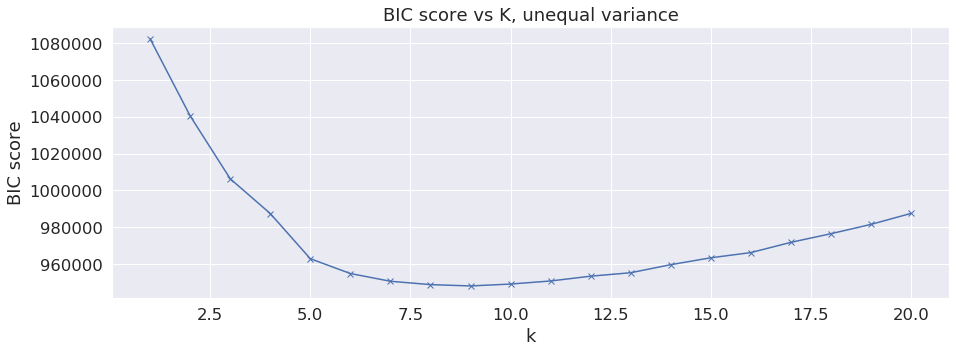

In [458]:
plt.figure(figsize = (15, 5))
plt.plot(K, bic_list3, 'bx-')
plt.xlabel('k')
plt.ylabel('BIC score')
plt.title('BIC score vs K, unequal variance')

## try 8 -10 clusters

In [459]:
from scipy.spatial import distance

def aic_score(km, dat):
    m = km.n_clusters
    N, d = dat.shape
    labels = km.labels_
    centers = km.cluster_centers_
    n = np.bincount(labels)
    cl_var = [(1.0 / (n[i] - m)) * sum(distance.cdist(dat[labels== i], np.reshape(centers[i], (1,-1)), 'euclidean')**2) for i in range(m)]
    const_term = 2*m*d  # 
    AIC = const_term - 2*sum(-n[i]/2*np.log(2*np.pi) - n[i]*d*np.log(cl_var[i][0]) - (n[i]-m)/2 + n[i]*np.log(n[i]) -n[i]*np.log(N) for i in range(m))
    return AIC    

In [460]:
aic_list = []
K = range(1,31)
for k in K:
    km = KMeans(n_clusters = k, random_state = 42)
    km = km.fit(all_data)
    aic = aic_score(km, all_data)
    aic_list.append(aic)

Text(0.5,1,'AIC score vs K, unequal variance')

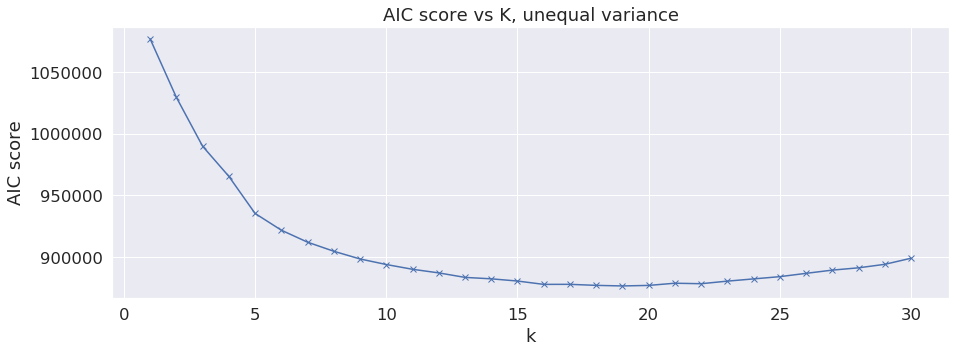

In [461]:
plt.figure(figsize = (15, 5))
plt.plot(K, aic_list, 'bx-')
plt.xlabel('k')
plt.ylabel('AIC score')
plt.title('AIC score vs K, unequal variance')

### 16 - 20 clusters 

In [462]:
## AIC, Mahalanobis distance

from scipy.spatial import distance

def aic_score2(km, dat):
    m = km.n_clusters
    N, d = dat.shape
    labels = km.labels_
    centers = km.cluster_centers_
    n = np.bincount(labels)
    cl_var = [(1.0 / (n[i] - m)) * sum(distance.cdist(dat[labels== i], np.reshape(centers[i], (1,-1)), 'mahalanobis')**2) for i in range(m)]
    const_term = 2*m*d  # 
    BIC = const_term - 2*sum(-n[i]/2*np.log(2*np.pi) - n[i]*d*np.log(cl_var[i][0]) - (n[i]-m)/2 + n[i]*np.log(n[i]) -n[i]*np.log(N) for i in range(m))
    return BIC    

In [463]:
aic_list2 = []
K = range(1,5)
for k in K:
    km = KMeans(n_clusters = k, random_state = 42)
    km = km.fit(all_data)
    aic = aic_score2(km, all_data)
    aic_list2.append(aic)

Text(0.5,1,'AIC score vs K, unequal variance, Mahalanobis')

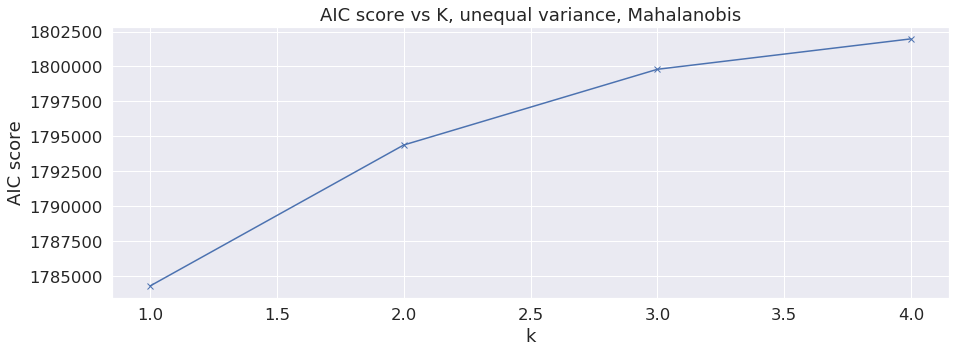

In [464]:
plt.figure(figsize = (15, 5))
plt.plot(K, aic_list2, 'bx-')
plt.xlabel('k')
plt.ylabel('AIC score')
plt.title('AIC score vs K, unequal variance, Mahalanobis')

In [465]:
### CAIC: consistent AIC, the penalty term is (1+log(n))*k. k = m*(d+1)

def caic_score(km, dat):
    m = km.n_clusters
    N, d = dat.shape
    labels = km.labels_
    n = np.bincount(labels)
    cl_var = km.inertia_/(N-m)
    const_term = (1+np.log(N))*m*(d+1)  # 
    CAIC = const_term - 2*sum(-n[i]/2*np.log(2*np.pi) - n[i]*d*np.log(cl_var) - (n[i]-m)/2 + n[i]*np.log(n[i]) -n[i]*np.log(N) for i in range(m))
    return CAIC    

In [466]:
caic_list = []
K = range(1, 51)
for k in K:
    km = KMeans(n_clusters = k, random_state = 42)
    km = km.fit(all_data)
    caic = caic_score(km, all_data)
    caic_list.append(caic)

Text(0.5,1,'CAIC score vs # of clusters K')

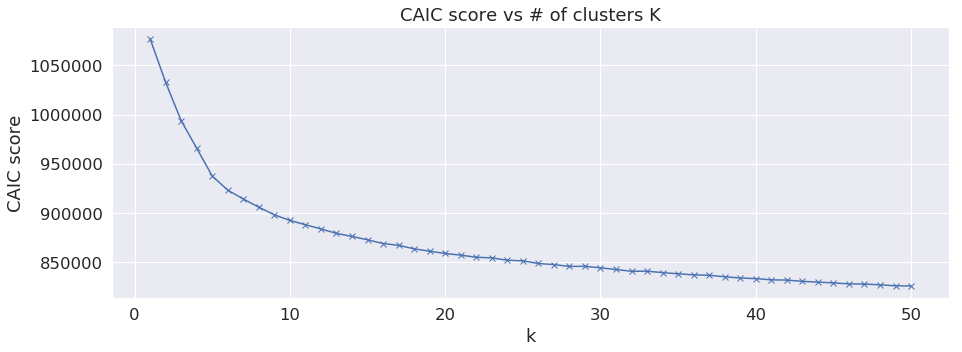

In [467]:
plt.figure(figsize = (15, 5))
plt.plot(K, caic_list, 'bx-')
plt.xlabel('k')
plt.ylabel('CAIC score')
plt.title('CAIC score vs # of clusters K')

In [481]:
### CAIC: consistent AIC, unequal variance, the penalty term is (1+log(n))*k. k = m - 1 + m*d*(d+1)/2 

def caic_score2(km, dat):
    m = km.n_clusters
    N, d = dat.shape
    labels = km.labels_
    n = np.bincount(labels)
    cl_var = [(1.0 / (n[i] - m)) * sum(distance.cdist(dat[labels== i], np.reshape(centers[i], (1,-1)), 'euclidean')**2) for i in range(m)]
    const_term = (1+np.log(N))*(m - 1 + m*d*(d+1)/2)  # 
    CAIC = const_term - 2*sum(-n[i]/2*np.log(2*np.pi) - n[i]*d*np.log(cl_var[i][0]) - (n[i]-m)/2 + n[i]*np.log(n[i]) -n[i]*np.log(N) for i in range(m))
    return CAIC    

In [483]:
caic_list2 = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters = k, random_state = 42)
    km = km.fit(all_data)
    caic = caic_score2(km, all_data)
    caic_list2.append(caic)

Text(0.5,1,'CAIC score vs # of clusters K, unequal variance')

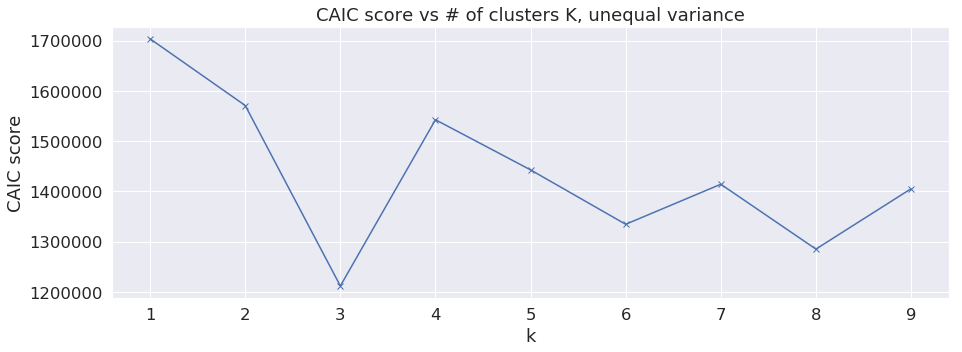

In [485]:
plt.figure(figsize = (15, 5))
plt.plot(K, caic_list2, 'bx-')
plt.xlabel('k')
plt.ylabel('CAIC score')
plt.title('CAIC score vs # of clusters K, unequal variance')

### 8 -11 clusters 

In [522]:
###  experimentation and interpretation 
## 6, 10, 15, 20 clusters, summary statistics


In [555]:
### try 6 clusters
kmeans6 = KMeans(n_clusters = 6, random_state = 42)
kmeans6.fit(all_data)

cluster_labels6 = kmeans6.labels_+1
#print(pd.Series(cluster_labels10).value_counts().sort_index())
#validation_data = validation_data.assign(cluster6 =cluster_labels6)
#for_clinical = for_clinical.assign(cluster10 =cluster_labels10)

In [524]:
cluster_size = pd.Series(cluster_labels6).value_counts().sort_index()
zip(cluster_size.index, cluster_size.values)

[(1, 1978), (2, 1944), (3, 235), (4, 191), (5, 2169), (6, 571)]

In [526]:
#for_clinical = for_clinical.assign(cluster6 =cluster_labels6)

In [ ]:

### try 10 clusters
kmeans10 = KMeans(n_clusters = 10, random_state = 42)
kmeans10.fit(all_data)

cluster_labels10 = kmeans10.labels_+1
#print(pd.Series(cluster_labels10).value_counts().sort_index())
validation_data = validation_data.assign(cluster10 =cluster_labels10)
#for_clinical = for_clinical.assign(cluster10 =cluster_labels10)

In [214]:
cluster_size = pd.Series(cluster_labels10).value_counts().sort_index()
zip(cluster_size.index, cluster_size.values)

[(1, 201),
 (2, 1013),
 (3, 902),
 (4, 268),
 (5, 1242),
 (6, 843),
 (7, 797),
 (8, 716),
 (9, 168),
 (10, 938)]

In [514]:
### try 15 clusters
kmeans15 = KMeans(n_clusters = 15, random_state = 42)
kmeans15.fit(all_data)

cluster_labels15 = kmeans15.labels_+1
print(pd.Series(cluster_labels15).value_counts().sort_index())
validation_data = validation_data.assign(cluster15 =cluster_labels15)
#for_clinical = for_clinical.assign(cluster15 =cluster_labels15)

1     600
2     761
3     165
4     241
5     787
6     384
7     195
8     542
9     348
10    401
11    618
12    518
13    497
14    556
15    475
dtype: int64


In [515]:
### try 20 clusters
kmeans20 = KMeans(n_clusters = 20, random_state = 42)
kmeans20.fit(all_data)

cluster_labels20 = kmeans20.labels_+1
#print(pd.Series(cluster_labels20).value_counts().sort_index())
#validation_data = validation_data.assign(cluster20 =cluster_labels20)
#for_clinical = for_clinical.assign(cluster20 =cluster_labels20)

In [527]:
median_cols = ['age', 'fac_cost', 'prof_cost',
       'rx_cost', 'total_cost', 'fac_claim_count', 'prof_claim_count',
       'rx_claim_count', 'ndc_count', 'ip_admits', 'ip_days', 'avg_los', 'er_visits', 
       'p10_imp_cost']


proportion_cols = ['gender_male', 'lang_english', 'state_TN', 'rural',
       'SUD_ind', 'Anxiety_ind', 'Depression_ind',
       'Asthma_ind', 'CHF_ind', 'CAD_ind', 'COPD_ind', 'Diabetes_ind',
       'Pneumonia_ind', 'Gallbladder_ind', 'Inju_Pois_ind', 'External_ind',
       'Arthritis_ind', 'Chro_Pain_ind', 'Smoking_ind', 'Obesity_ind',
       'Bipolar_ind', 'Hypertension_ind', 'Adjustment_ind', 'ADHD_ind',
       'Dementia_ind', 'Development_ind', 'Personal_ind',
       'Schizophrenia_ind', 'Suicide_ind', 'Mental_Retard_ind',
       'Other_Psych_ind']


In [537]:
overall_median = for_clinical[median_cols].median()
overall_prop = for_clinical[proportion_cols].mean()


clst6_median = for_clinical.groupby('cluster6')[median_cols].median()
clst6_prop = for_clinical.groupby('cluster6')[proportion_cols].mean()

clst10_median = for_clinical.groupby('cluster10')[median_cols].median()
clst10_prop = for_clinical.groupby('cluster10')[proportion_cols].mean()

clst15_median = for_clinical.groupby('cluster15')[median_cols].median()
clst15_prop = for_clinical.groupby('cluster15')[proportion_cols].mean()

clst20_median = for_clinical.groupby('cluster20')[median_cols].median()
clst20_prop = for_clinical.groupby('cluster20')[proportion_cols].mean()

In [540]:
#overall_prop

In [541]:
import xlsxwriter
writer = pd.ExcelWriter('cluster_stats2.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
overall_median.to_excel(writer, sheet_name='median_overall')
overall_prop.to_excel(writer, sheet_name='propotion_overall')

clst6_median.to_excel(writer, sheet_name='median_6_clusters')
clst6_prop.to_excel(writer, sheet_name='propotion_6_clusters')


clst10_median.to_excel(writer, sheet_name='median_10_clusters')
clst10_prop.to_excel(writer, sheet_name='propotion_10_clusters')

clst15_median.to_excel(writer, sheet_name='median_15_clusters')
clst15_prop.to_excel(writer, sheet_name='propotion_15_clusters')

clst20_median.to_excel(writer, sheet_name='median_20_clusters')
clst20_prop.to_excel(writer, sheet_name='propotion_20_clusters')


# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [215]:
cluster_size = pd.Series(cluster_labels15).value_counts().sort_index()
zip(cluster_size.index, cluster_size.values)

[(1, 600),
 (2, 761),
 (3, 165),
 (4, 241),
 (5, 787),
 (6, 384),
 (7, 195),
 (8, 542),
 (9, 348),
 (10, 401),
 (11, 618),
 (12, 518),
 (13, 497),
 (14, 556),
 (15, 475)]

In [506]:
### try 25 clusters
kmeans25 = KMeans(n_clusters = 25, random_state = 42)
kmeans25.fit(all_data)

cluster_labels25 = kmeans25.labels_+1
print(pd.Series(cluster_labels25).value_counts().sort_index())
validation_data = validation_data.assign(cluster25 =cluster_labels25)


1     301
2     343
3     338
4     269
5     192
6     302
7     301
8     164
9     269
10    230
11    297
12    336
13    349
14    247
15    326
16    357
17    274
18    311
19    205
20    332
21    212
22    277
23    380
24    286
25    190
dtype: int64


In [559]:
# import xlsxwriter
# writer = pd.ExcelWriter('member_data_with_cluster_labels.xlsx', engine='xlsxwriter')

# # Convert the dataframe to an XlsxWriter Excel object.
# for_clinical.to_excel(writer, sheet_name='Sheet1')

# # Close the Pandas Excel writer and output the Excel file.
# writer.save()

In [172]:
### try 30 clusters
kmeans30 = KMeans(n_clusters = 30, random_state = 42)
kmeans30.fit(all_data)

cluster_labels30 = kmeans30.labels_+1
print(pd.Series(cluster_labels30).value_counts().sort_index())
validation_data = validation_data.assign(cluster30 =cluster_labels30)

1     227
2     243
3     238
4     410
5     278
6     291
7      43
8     220
9     294
10     87
11    222
12    212
13    281
14    216
15    247
16    359
17    274
18    299
19    215
20    224
21    211
22    230
23    260
24    105
25    126
26    262
27    326
28    233
29    191
30    264
dtype: int64


In [173]:
### try 35 clusters
kmeans35 = KMeans(n_clusters = 35, random_state = 42)
kmeans35.fit(all_data)

cluster_labels35 = kmeans35.labels_+1
print(pd.Series(cluster_labels35).value_counts().sort_index())
validation_data = validation_data.assign(cluster35 =cluster_labels35)

1     198
2     192
3     312
4     244
5     250
6     126
7     214
8      90
9     203
10    220
11    325
12    167
13    213
14    315
15    199
16    203
17    173
18    228
19    232
20    196
21    152
22    201
23    255
24    190
25    197
26    204
27    210
28    238
29    207
30    102
31     44
32    181
33    174
34    250
35    183
dtype: int64


In [174]:
### try 40 clusters
kmeans40 = KMeans(n_clusters = 40, random_state = 42)
kmeans40.fit(all_data)

cluster_labels40 = kmeans40.labels_+1
print(pd.Series(cluster_labels40).value_counts().sort_index())
validation_data = validation_data.assign(cluster40 =cluster_labels40)

1     151
2     151
3     261
4     216
5     229
6     125
7     205
8      90
9     206
10    189
11    293
12    139
13    191
14    274
15    185
16    139
17    137
18    202
19    198
20    195
21    158
22    191
23    243
24    179
25    174
26    151
27    197
28    202
29    177
30    102
31     44
32    167
33    161
34    209
35    159
36    156
37    134
38    126
39    202
40    180
dtype: int64


In [175]:
### try 45 clusters
kmeans45 = KMeans(n_clusters = 45, random_state = 42)
kmeans45.fit(all_data)

cluster_labels45 = kmeans45.labels_+1
print(pd.Series(cluster_labels45).value_counts().sort_index())
validation_data = validation_data.assign(cluster45 =cluster_labels45)

1     154
2     138
3     232
4     190
5     181
6     126
7     101
8      90
9     188
10    163
11    146
12    131
13    161
14    249
15    176
16     98
17    144
18    171
19    176
20    172
21    115
22    177
23    220
24    166
25    158
26    149
27    173
28    169
29    166
30    101
31     44
32    158
33    164
34    142
35    146
36    144
37    126
38    132
39    188
40    164
41    174
42    163
43    126
44    198
45    238
dtype: int64


In [176]:
### try 50 clusters
kmeans50 = KMeans(n_clusters = 50, random_state = 42)
kmeans50.fit(all_data)

cluster_labels50 = kmeans50.labels_+1
print(pd.Series(cluster_labels50).value_counts().sort_index())
validation_data = validation_data.assign(cluster50 =cluster_labels50)

1      87
2     171
3     139
4     139
5     140
6     122
7     162
8     150
9     125
10    177
11    175
12    191
13    156
14    109
15    120
16    100
17    161
18     90
19    151
20    178
21    157
22    170
23    207
24    185
25    199
26     95
27    136
28    143
29    157
30    164
31    138
32    139
33    176
34    109
35    174
36    133
37    138
38    164
39    102
40     20
41    158
42    177
43    136
44    154
45     61
46    135
47    139
48    101
49    138
50    140
dtype: int64


In [177]:
########### interpret and evaluate the clusters 


# df.groupby(clusterId).describe()
# df.groupby(clusterId).mean()
# df.groupby('clusterId').describe()
# df.groupby('clusterId').age.mean()

In [530]:
centroids = pd.DataFrame(kmeans6.cluster_centers_)
centroids.columns = allCols
centroids

gender_male  lang_english  state_TN     rural   ageLt65  age65to75  \
0     0.365521      0.921132  0.346815  0.211325  0.366026   0.396866   
1     0.342078      0.944959  0.666667  0.230453  0.277778   0.411523   
2     0.400000      0.723404  0.085106  0.097872  0.323404   0.408511   
3     0.345550      0.979058  0.947644  0.235602  0.214660   0.471204   
4     0.271554      0.875519  0.272476  0.239281  0.258183   0.488704   
5     0.500876      0.968476  0.732049  0.246935  0.178634   0.551664   

    SUD_ind  Anxiety_ind  Depression_ind  Asthma_ind  ...  Development_ind  \
0  0.338220     0.648129        0.707786    0.206775  ...         0.033873   
1  0.236626     0.636831        0.629630    0.105453  ...         0.024177   
2  0.174468     0.476596        0.706383    0.046809  ...         0.008511   
3  0.287958     0.544503        0.565445    0.109948  ...         0.005236   
4  0.215768     0.595205        0.623790    0.115260  ...         0.007377   
5  0.313485     0.562172        0.514886    0.054291  ...         0.019264   

   Schizophrenia_ind  Other_Psych_ind  facTrans  profTrans   rxTrans  \
0           0.058645         0.761881  0.627091   0.540659  0.823887   
1           0.041667         0.589506  0.366886  -0.259230 -0.093768   
2           0.038298         0.336170 -4.002688   0.870675  0.112674   
3           0.015707         0.706806  0.486292  -4.419210 -0.167687   
4           0.013831         0.501614 -0.544940   0.118006 -0.097991   
5           0.024518         0.605954  0.133293  -0.318692 -2.152842   

     ipNone     ipLow    erNone     erLow  
0  0.123357  0.487361  0.242669  0.432255  
1  0.028807  0.722222  0.477366  0.382716  
2  0.978723  0.021277  0.991489  0.008511  
3  0.083770  0.471204  0.413613  0.439791  
4  0.978792  0.006916  0.420931  0.426003  
5  0.371278  0.411559  0.402802  0.423818  

[6 rows x 35 columns]

In [531]:
####  evaluate clusters when K == 6

In [532]:
# dummyVars = ['gender_male', 'lang_english', 'state_TN', 'rural', 'ageLt65', 'age65to75', 'SUD_ind', 'Anxiety_ind', 
#              'Depression_ind', 'Asthma_ind', 'CHF_ind', 'CAD_ind', 'COPD_ind', 'Diabetes_ind', 'Pneumonia_ind', 
#              'Gallbladder_ind', 'Inju_Pois_ind', 'External_ind', 'Arthritis_ind', 'Chro_Pain_ind', 'Smoking_ind', 
#              'Bipolar_ind', 'Hypertension_ind', 'Adjustment_ind', 'Dementia_ind', 'Development_ind', 'Schizophrenia_ind', 
#              'Other_Psych_ind', 'ipNone', 'ipLow', 'erNone', 'erLow']

nClusters = 6

for i in range(len(original_dummy_cols)):
    benchMark = validation_data[original_dummy_cols[i]].mean()
    print('')
    print('----------' + original_dummy_cols[i] + ' overall proportion is: ' + str(round(benchMark,3)) + '---------------')
    print('')
    for j in range(1, nClusters+1):
        successInCluster = validation_data[validation_data.cluster6 == j][original_dummy_cols[i]].sum()
        trialInCluster = (validation_data.cluster6 == j).sum()
        failureInCluster = trialInCluster - successInCluster
        if ((successInCluster >= 5) &  (failureInCluster >=5)):
            pValue = stats.binom_test(successInCluster, n = trialInCluster, p=benchMark)
            if (pValue < 0.05):
                diff = round(abs((successInCluster*1.0/trialInCluster - benchMark)),3)
                if (successInCluster*1.0/trialInCluster > benchMark):
                    print(original_dummy_cols[i] + ' in cluster ' + str(j) + ' is bigger than bench mark by ' + str(diff) )
                else:
                    print(original_dummy_cols[i] + ' in cluster ' + str(j) + ' is smaller than bench mark by ' + str(diff))
            else:
                print(original_dummy_cols[i] + ' in cluster ' + str(j) + ' is not significant')
        else:
            print('perfect seperation, can not perform binomial test for ' + original_dummy_cols[i] + ' in cluster ' + str(j))
            print(original_dummy_cols[i] + ' positive: '+ str(successInCluster) + ', negative: '+ str(failureInCluster))






----------gender_male overall proportion is: 0.342---------------

gender_male in cluster 1 is bigger than bench mark by 0.024
gender_male in cluster 2 is not significant
gender_male in cluster 3 is not significant
gender_male in cluster 4 is not significant
gender_male in cluster 5 is smaller than bench mark by 0.07
gender_male in cluster 6 is bigger than bench mark by 0.159

----------lang_english overall proportion is: 0.913---------------

lang_english in cluster 1 is not significant
lang_english in cluster 2 is bigger than bench mark by 0.032
lang_english in cluster 3 is smaller than bench mark by 0.189
perfect seperation, can not perform binomial test for lang_english in cluster 4
lang_english positive: 187, negative: 4
lang_english in cluster 5 is smaller than bench mark by 0.037
lang_english in cluster 6 is bigger than bench mark by 0.056

----------state_TN overall proportion is: 0.45---------------

state_TN in cluster 1 is smaller than bench mark by 0.104
state_TN in cluste

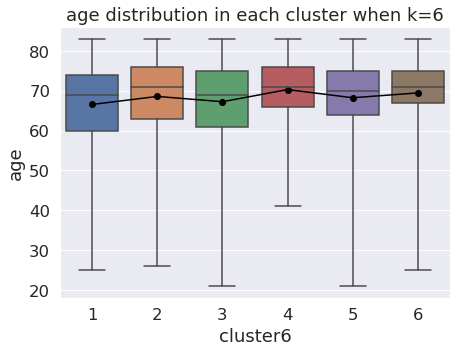

In [533]:
### can compare IQR
plt.figure(figsize=(7, 5))
sns.boxplot(x='cluster6', y ='age', data = validation_data, whis=10)
cluster6_age = validation_data.groupby('cluster6').age.mean()
plt.plot(cluster6_age.index -1, cluster6_age.values, 'o-', color = 'black')
plt.title('age distribution in each cluster when k=6')
plt.show()

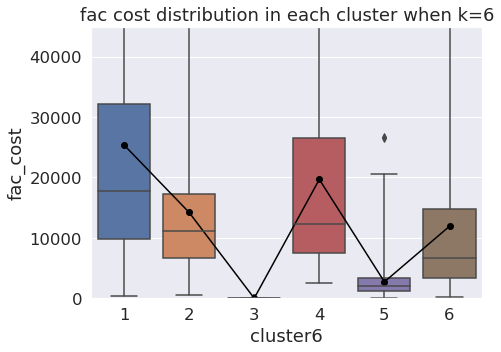

In [536]:
### can compare IQR
plt.figure(figsize=(7, 5))
plt.ylim((0, np.percentile(validation_data.fac_cost, 95)))
sns.boxplot(x='cluster6', y ='fac_cost', data = validation_data, whis=10)
cluster6_fac = validation_data.groupby('cluster6').fac_cost.mean()
plt.plot(cluster6_fac.index -1, cluster6_fac.values, 'o-', color = 'black')
plt.title('fac cost distribution in each cluster when k=6')
plt.show()

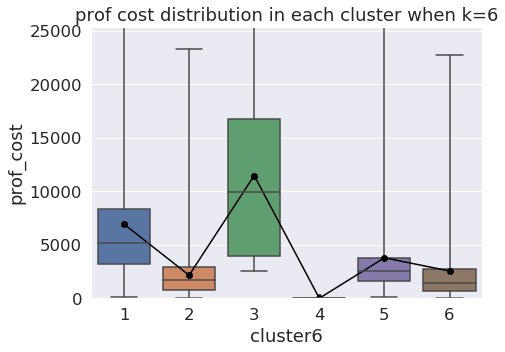

In [542]:
### can compare IQR
plt.figure(figsize=(7, 5))
plt.ylim((0, np.percentile(validation_data.prof_cost, 99)))
sns.boxplot(x='cluster6', y ='prof_cost', data = validation_data, whis=10)
cluster6_prof = validation_data.groupby('cluster6').prof_cost.mean()
plt.plot(cluster6_prof.index -1, cluster6_prof.values, 'o-', color = 'black')
plt.title('prof cost distribution in each cluster when k=6')
plt.show()

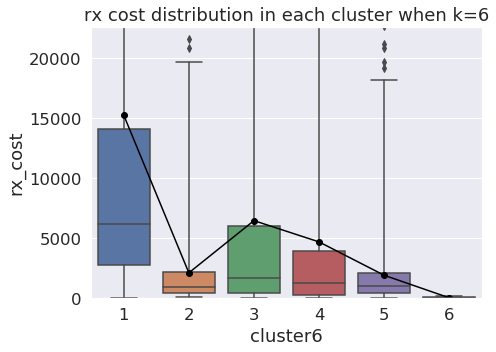

In [543]:
### can compare IQR
plt.figure(figsize=(7, 5))
plt.ylim((0, np.percentile(validation_data.rx_cost, 95)))
sns.boxplot(x='cluster6', y ='rx_cost', data = validation_data, whis=10)
cluster6_rx = validation_data.groupby('cluster6').rx_cost.mean()
plt.plot(cluster6_rx.index -1, cluster6_rx.values, 'o-', color = 'black')
plt.title('rx cost distribution in each cluster when k=6')
plt.show()

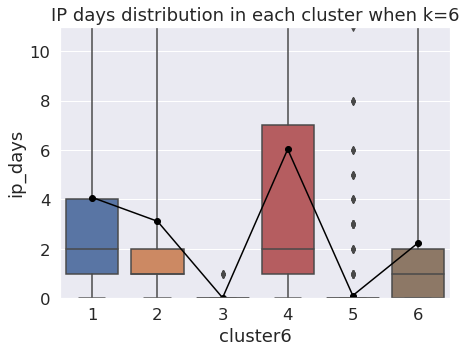

In [544]:
### can compare IQR
plt.figure(figsize=(7, 5))
plt.ylim((0, np.percentile(validation_data.ip_days, 95)))
sns.boxplot(x='cluster6', y ='ip_days', data = validation_data, whis=10)
cluster6_ip = validation_data.groupby('cluster6').ip_days.mean()
plt.plot(cluster6_ip.index -1, cluster6_ip.values, 'o-', color = 'black')
plt.title('IP days distribution in each cluster when k=6')
plt.show()

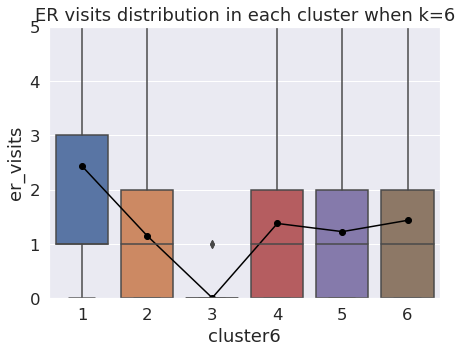

In [545]:
### can compare IQR
plt.figure(figsize=(7, 5))
plt.ylim((0, np.percentile(validation_data.er_visits, 95)))
sns.boxplot(x='cluster6', y ='er_visits', data = validation_data, whis=10)
cluster6_er = validation_data.groupby('cluster6').er_visits.mean()
plt.plot(cluster6_er.index -1, cluster6_er.values, 'o-', color = 'black')
plt.title('ER visits distribution in each cluster when k=6')
plt.show()

In [550]:
### relative importance of segment attributes k =6
cluster_avg = validation_data[original_cols+ ['cluster6']].groupby('cluster6').mean()
population_avg = validation_data[original_cols].mean()
relative_imp = cluster_avg/population_avg - 1

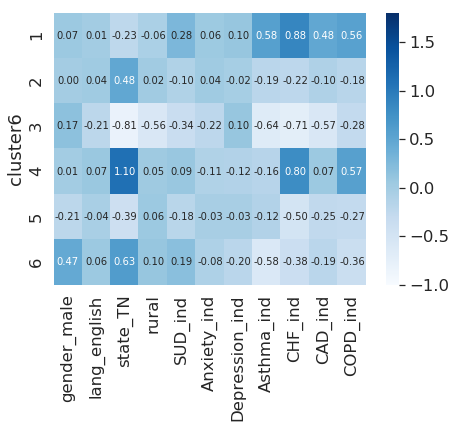

In [551]:
plt.figure(figsize=(7, 5))
sns.heatmap(relative_imp.iloc[:,:11], annot=True, fmt='.2f', vmin=-1.0, vmax=1.8, cmap ='Blues') # 

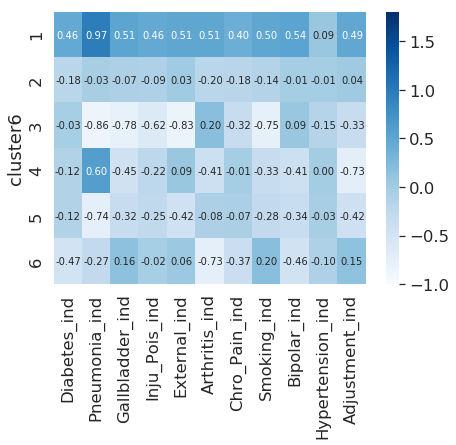

In [552]:
plt.figure(figsize=(7, 5))
sns.heatmap(relative_imp.iloc[:,11:22], annot=True, fmt='.2f', vmin=-1.0, vmax=1.8, cmap ='Blues') #

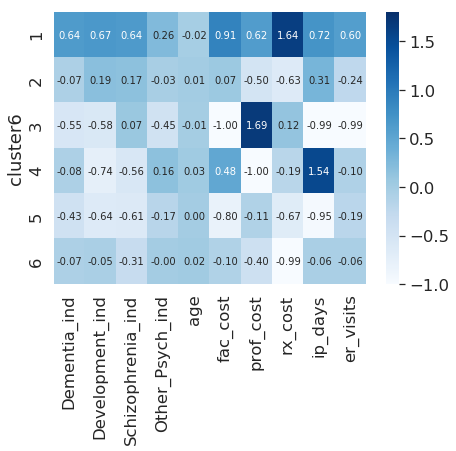

In [553]:
plt.figure(figsize=(7, 5))
sns.heatmap(relative_imp.iloc[:,22:], annot=True, fmt='.2f', vmin=-1.0, vmax=1.8, cmap ='Blues') #

In [178]:
#dir(kmeans10)

centroids = pd.DataFrame(kmeans10.cluster_centers_)
centroids.columns = allCols
centroids

gender_male  lang_english  state_TN     rural   ageLt65  age65to75  \
0     0.412935      0.726368  0.084577  0.079602  0.318408   0.412935   
1     0.332675      0.913129  0.432379  0.235933  0.012833   0.620928   
2     0.452328      0.941242  0.531042  0.216186  0.259424   0.451220   
3     0.544776      0.970149  0.723881  0.246269  0.175373   0.548507   
4     0.285829      0.880032  0.291465  0.209340  0.277778   0.469404   
5     0.352313      0.881376  0.391459  0.168446  0.214709   0.487544   
6     0.346299      0.968632  0.378921  0.233375  0.967378   0.006274   
7     0.304469      0.991620  0.974860  0.270950  0.233240   0.418994   
8     0.339286      0.976190  0.940476  0.238095  0.214286   0.482143   
9     0.262260      0.859275  0.228145  0.272921  0.197228   0.533049   

    SUD_ind  Anxiety_ind  Depression_ind  Asthma_ind  ...  Development_ind  \
0  0.184080     0.497512        0.696517    0.044776  ...         0.009950   
1  0.222113     0.619941        0.699901    0.183613  ...         0.033564   
2  0.388027     0.609756        0.587583    0.084257  ...         0.031042   
3  0.283582     0.563433        0.544776    0.052239  ...         0.022388   
4  0.210950     0.621578        0.611916    0.115942  ...         0.008052   
5  0.196916     0.553974        0.661922    0.153025  ...         0.026097   
6  0.490590     0.765370        0.750314    0.227102  ...         0.033877   
7  0.167598     0.646648        0.572626    0.103352  ...         0.015363   
8  0.285714     0.553571        0.583333    0.113095  ...         0.005952   
9  0.210021     0.547974        0.635394    0.101279  ...         0.003198   

   Schizophrenia_ind  Other_Psych_ind  facTrans  profTrans   rxTrans  \
0           0.044776         0.348259 -4.302164   0.872846  0.072186   
1           0.028628         0.689042  0.645403   0.445206  0.738007   
2           0.046563         0.710643  0.441293   0.173581 -0.664659   
3           0.018657         0.585821  0.115922  -0.267674 -2.981551   
4           0.016103         0.529791 -0.443936   0.066623 -0.160620   
5           0.021352         0.553974  0.437761   0.193729  0.508261   
6           0.127980         0.877039  0.528958   0.512428  0.899336   
7           0.027933         0.530726  0.265287  -1.115417 -0.212406   
8           0.017857         0.726190  0.493474  -4.679342 -0.156479   
9           0.005330         0.436034 -0.778534   0.233512 -0.139558   

     ipNone     ipLow        erNone         erLow  
0  0.990050  0.009950  9.950249e-01  4.975124e-03  
1  0.115499  0.449161  4.442251e-02  6.396841e-01  
2  0.023282  0.730599  2.849224e-01  5.077605e-01  
3  0.376866  0.376866  4.328358e-01  3.955224e-01  
4  0.970209  0.009662 -1.065814e-14  7.737520e-01  
5  0.027284  0.755635  9.584816e-01  2.372479e-03  
6  0.202008  0.466750  1.417817e-01  4.052698e-01  
7  0.192737  0.518156  4.567039e-01  3.868715e-01  
8  0.071429  0.494048  4.166667e-01  4.464286e-01  
9  0.963753  0.022388  9.882729e-01 -4.996004e-15  

[10 rows x 35 columns]

In [179]:
####  evaluate clusters when K == 10

In [180]:
# dummyVars = ['gender_male', 'lang_english', 'state_TN', 'rural', 'ageLt65', 'age65to75', 'SUD_ind', 'Anxiety_ind', 
#              'Depression_ind', 'Asthma_ind', 'CHF_ind', 'CAD_ind', 'COPD_ind', 'Diabetes_ind', 'Pneumonia_ind', 
#              'Gallbladder_ind', 'Inju_Pois_ind', 'External_ind', 'Arthritis_ind', 'Chro_Pain_ind', 'Smoking_ind', 
#              'Bipolar_ind', 'Hypertension_ind', 'Adjustment_ind', 'Dementia_ind', 'Development_ind', 'Schizophrenia_ind', 
#              'Other_Psych_ind', 'ipNone', 'ipLow', 'erNone', 'erLow']

nClusters = 10

for i in range(len(original_dummy_cols)):
    benchMark = validation_data[original_dummy_cols[i]].mean()
    print('')
    print('----------' + original_dummy_cols[i] + ' bench mark is: ' + str(round(benchMark,3)) + '---------------')
    print('')
    for j in range(1, nClusters+1):
        successInCluster = validation_data[validation_data.cluster10 == j][original_dummy_cols[i]].sum()
        trialInCluster = (validation_data.cluster10 == j).sum()
        failureInCluster = trialInCluster - successInCluster
        if ((successInCluster >= 5) &  (failureInCluster >=5)):
            pValue = stats.binom_test(successInCluster, n = trialInCluster, p=benchMark)
            if (pValue < 0.05):
                diff = round(abs((successInCluster*1.0/trialInCluster - benchMark)),3)
                if (successInCluster*1.0/trialInCluster > benchMark):
                    print(original_dummy_cols[i] + ' in cluster ' + str(j) + ' is bigger than bench mark by ' + str(diff) )
                else:
                    print(original_dummy_cols[i] + ' in cluster ' + str(j) + ' is smaller than bench mark by ' + str(diff))
            else:
                print(original_dummy_cols[i] + ' in cluster ' + str(j) + ' is not significant')
        else:
            print('perfect seperation, can not perform binomial test for ' + original_dummy_cols[i] + ' in cluster ' + str(j))
            print(original_dummy_cols[i] + ' positive: '+ str(successInCluster) + ', negative: '+ str(failureInCluster))






----------gender_male bench mark is: 0.342---------------

gender_male in cluster 1 is bigger than bench mark by 0.071
gender_male in cluster 2 is not significant
gender_male in cluster 3 is bigger than bench mark by 0.11
gender_male in cluster 4 is bigger than bench mark by 0.203
gender_male in cluster 5 is smaller than bench mark by 0.056
gender_male in cluster 6 is not significant
gender_male in cluster 7 is not significant
gender_male in cluster 8 is smaller than bench mark by 0.037
gender_male in cluster 9 is not significant
gender_male in cluster 10 is smaller than bench mark by 0.08

----------lang_english bench mark is: 0.913---------------

lang_english in cluster 1 is smaller than bench mark by 0.186
lang_english in cluster 2 is not significant
lang_english in cluster 3 is bigger than bench mark by 0.029
lang_english in cluster 4 is bigger than bench mark by 0.058
lang_english in cluster 5 is smaller than bench mark by 0.032
lang_english in cluster 6 is smaller than bench ma

Arthritis_ind in cluster 10 is not significant

----------Chro_Pain_ind bench mark is: 0.334---------------

Chro_Pain_ind in cluster 1 is smaller than bench mark by 0.12
Chro_Pain_ind in cluster 2 is bigger than bench mark by 0.048
Chro_Pain_ind in cluster 3 is not significant
Chro_Pain_ind in cluster 4 is smaller than bench mark by 0.14
Chro_Pain_ind in cluster 5 is not significant
Chro_Pain_ind in cluster 6 is smaller than bench mark by 0.08
Chro_Pain_ind in cluster 7 is bigger than bench mark by 0.297
Chro_Pain_ind in cluster 8 is smaller than bench mark by 0.092
Chro_Pain_ind in cluster 9 is not significant
Chro_Pain_ind in cluster 10 is smaller than bench mark by 0.048

----------Smoking_ind bench mark is: 0.102---------------

Smoking_ind in cluster 1 is smaller than bench mark by 0.077
Smoking_ind in cluster 2 is not significant
Smoking_ind in cluster 3 is bigger than bench mark by 0.03
Smoking_ind in cluster 4 is not significant
Smoking_ind in cluster 5 is not significant
Smok

In [181]:
### numeric vars 
### original_num_cols = ['age', 'fac_cost', 'prof_cost', 'rx_cost', 'ip_days', 'er_visits']

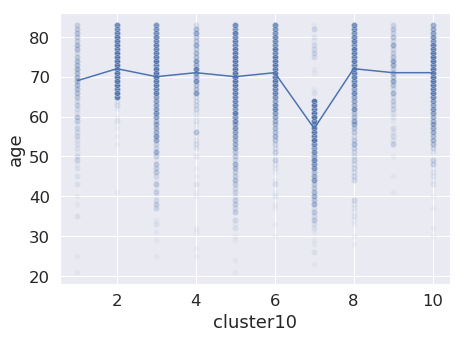

In [182]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x='cluster10', y ='age', data = validation_data, alpha = 0.05)
plt.plot(validation_data.groupby('cluster10').age.median())
plt.show()

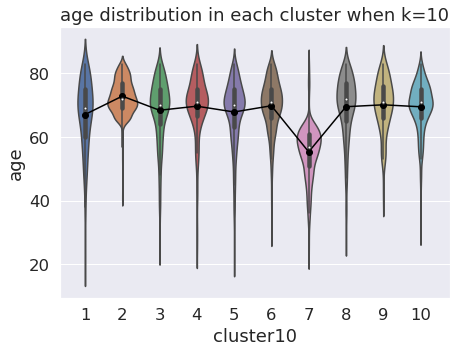

In [183]:
plt.figure(figsize=(7, 5))
sns.violinplot(x='cluster10', y ='age', data = validation_data, Inner = None)

cluster10_age = validation_data.groupby('cluster10').age.mean()
plt.plot(cluster10_age.index -1, cluster10_age.values, 'o-', color = 'black')
plt.title('age distribution in each cluster when k=10')
plt.show()

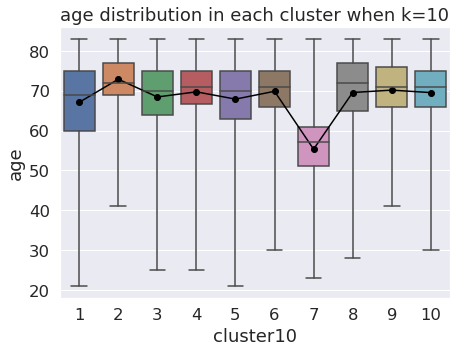

In [184]:
### can compare IQR
plt.figure(figsize=(7, 5))
sns.boxplot(x='cluster10', y ='age', data = validation_data, whis=10)
cluster10_age = validation_data.groupby('cluster10').age.mean()
plt.plot(cluster10_age.index -1, cluster10_age.values, 'o-', color = 'black')
plt.title('age distribution in each cluster when k=10')
plt.show()

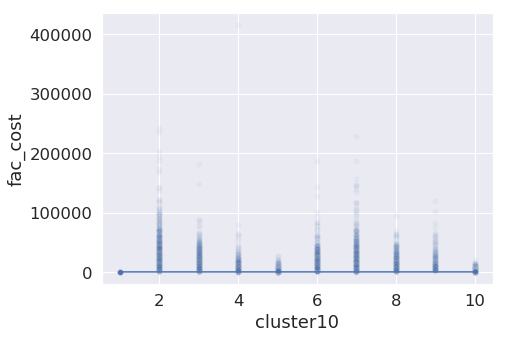

In [185]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x='cluster10', y ='fac_cost', data = validation_data, alpha = 0.05)
plt.plot(validation_data.groupby('cluster10').age.median())
plt.show()

In [186]:
#validation_data.loc[validation_data.cluster10==1, 'fac_cost'].sort_values()

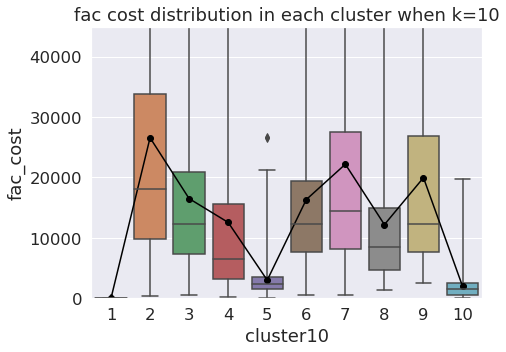

In [187]:
### can compare IQR
plt.figure(figsize=(7, 5))
plt.ylim((0, np.percentile(validation_data.fac_cost, 95)))
sns.boxplot(x='cluster10', y ='fac_cost', data = validation_data, whis=10)
cluster10_fac = validation_data.groupby('cluster10').fac_cost.mean()
plt.plot(cluster10_fac.index -1, cluster10_fac.values, 'o-', color = 'black')
plt.title('fac cost distribution in each cluster when k=10')
plt.show()

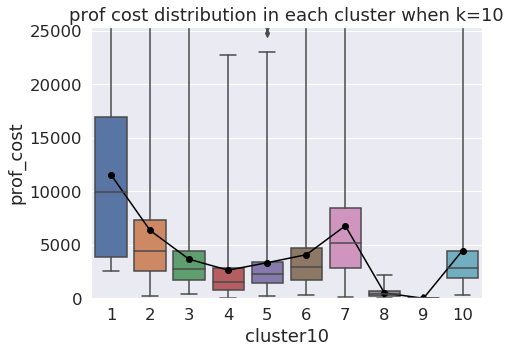

In [188]:
### can compare IQR
plt.figure(figsize=(7, 5))
plt.ylim((0, np.percentile(validation_data.prof_cost, 99)))
sns.boxplot(x='cluster10', y ='prof_cost', data = validation_data, whis=10)
cluster10_prof = validation_data.groupby('cluster10').prof_cost.mean()
plt.plot(cluster10_prof.index -1, cluster10_prof.values, 'o-', color = 'black')
plt.title('prof cost distribution in each cluster when k=10')
plt.show()

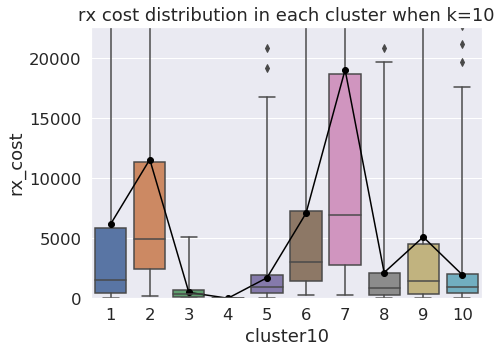

In [189]:
### can compare IQR
plt.figure(figsize=(7, 5))
plt.ylim((0, np.percentile(validation_data.rx_cost, 95)))
sns.boxplot(x='cluster10', y ='rx_cost', data = validation_data, whis=10)
cluster10_rx = validation_data.groupby('cluster10').rx_cost.mean()
plt.plot(cluster10_rx.index -1, cluster10_rx.values, 'o-', color = 'black')
plt.title('rx cost distribution in each cluster when k=10')
plt.show()

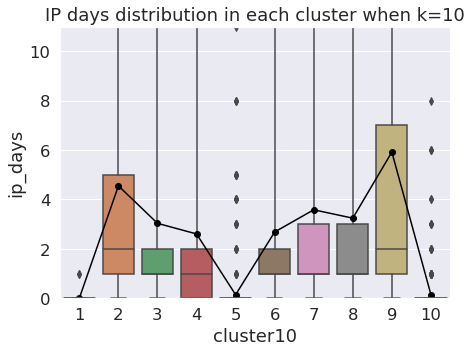

In [190]:
### can compare IQR
plt.figure(figsize=(7, 5))
plt.ylim((0, np.percentile(validation_data.ip_days, 95)))
sns.boxplot(x='cluster10', y ='ip_days', data = validation_data, whis=10)
cluster10_ip = validation_data.groupby('cluster10').ip_days.mean()
plt.plot(cluster10_ip.index -1, cluster10_ip.values, 'o-', color = 'black')
plt.title('IP days distribution in each cluster when k=10')
plt.show()

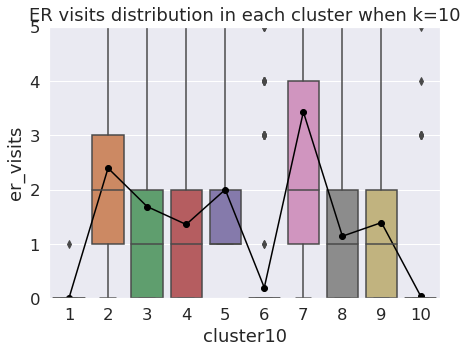

In [191]:
### can compare IQR
plt.figure(figsize=(7, 5))
plt.ylim((0, np.percentile(validation_data.er_visits, 95)))
sns.boxplot(x='cluster10', y ='er_visits', data = validation_data, whis=10)
cluster10_er = validation_data.groupby('cluster10').er_visits.mean()
plt.plot(cluster10_er.index -1, cluster10_er.values, 'o-', color = 'black')
plt.title('ER visits distribution in each cluster when k=10')
plt.show()

In [192]:
### relative importance of segment attributes k =10
cluster_avg = validation_data[original_cols+ ['cluster10']].groupby('cluster10').mean()
population_avg = validation_data[original_cols].mean()
relative_imp = cluster_avg/population_avg - 1

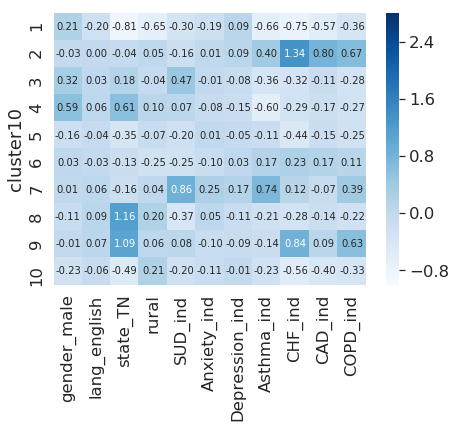

In [209]:
plt.figure(figsize=(7, 5))
sns.heatmap(relative_imp.iloc[:,:11], annot=True, fmt='.2f', vmin=-1.0, vmax=2.8, cmap ='Blues')

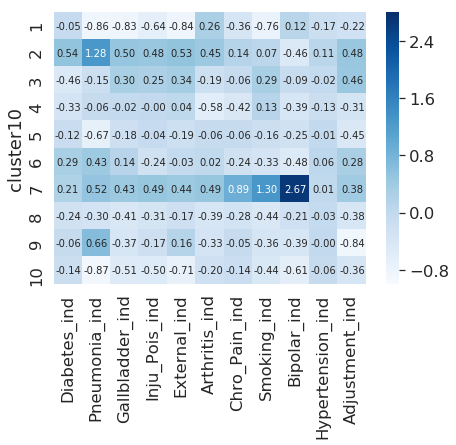

In [210]:
plt.figure(figsize=(7, 5))
sns.heatmap(relative_imp.iloc[:,11:22], annot=True, fmt='.2f', vmin=-1.0, vmax=2.8, cmap ='Blues')

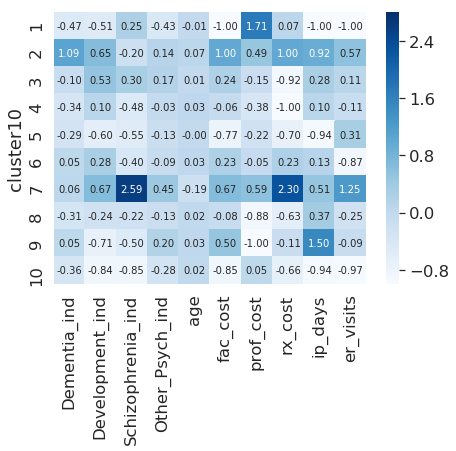

In [211]:
plt.figure(figsize=(7, 5))
sns.heatmap(relative_imp.iloc[:,22:], annot=True, fmt='.2f', vmin=-1.0, vmax=2.8, cmap ='Blues')

In [202]:
# corr_matrix = all_data.corr()
# corr_matrix.columns = allCols
# corr_matrix.index = allCols

In [197]:
# plt.figure(figsize = (10,8))
# sns.heatmap(corr_matrix)

In [212]:
## evaluate K == 15 clusters

In [213]:

nClusters = 15

for i in range(len(original_dummy_cols)):
    benchMark = validation_data[original_dummy_cols[i]].mean()
    print('')
    print('----------' + original_dummy_cols[i] + ' bench mark is: ' + str(round(benchMark,3)) + '---------------')
    print('')
    for j in range(1, nClusters+1):
        successInCluster = validation_data[validation_data.cluster15 == j][original_dummy_cols[i]].sum()
        trialInCluster = (validation_data.cluster15 == j).sum()
        failureInCluster = trialInCluster - successInCluster
        if ((successInCluster >= 5) &  (failureInCluster >=5)):
            pValue = stats.binom_test(successInCluster, n = trialInCluster, p=benchMark)
            if (pValue < 0.05):
                diff = round(abs((successInCluster*1.0/trialInCluster - benchMark)),3)
                if (successInCluster*1.0/trialInCluster > benchMark):
                    print(original_dummy_cols[i] + ' in cluster ' + str(j) + ' is bigger than bench mark by ' + str(diff) )
                else:
                    print(original_dummy_cols[i] + ' in cluster ' + str(j) + ' is smaller than bench mark by ' + str(diff))
            else:
                print(original_dummy_cols[i] + ' in cluster ' + str(j) + ' is not significant')
        else:
            print('perfect seperation, can not perform binomial test for ' + original_dummy_cols[i] + ' in cluster ' + str(j))
            print(original_dummy_cols[i] + ' positive: '+ str(successInCluster) + ', negative: '+ str(failureInCluster))






----------gender_male bench mark is: 0.342---------------

gender_male in cluster 1 is smaller than bench mark by 0.1
gender_male in cluster 2 is smaller than bench mark by 0.115
gender_male in cluster 3 is not significant
gender_male in cluster 4 is bigger than bench mark by 0.202
gender_male in cluster 5 is smaller than bench mark by 0.088
gender_male in cluster 6 is not significant
gender_male in cluster 7 is bigger than bench mark by 0.079
gender_male in cluster 8 is not significant
gender_male in cluster 9 is smaller than bench mark by 0.092
gender_male in cluster 10 is bigger than bench mark by 0.481
gender_male in cluster 11 is bigger than bench mark by 0.047
gender_male in cluster 12 is bigger than bench mark by 0.05
gender_male in cluster 13 is not significant
gender_male in cluster 14 is smaller than bench mark by 0.045
gender_male in cluster 15 is smaller than bench mark by 0.051

----------lang_english bench mark is: 0.913---------------

lang_english in cluster 1 is not s

Diabetes_ind in cluster 10 is smaller than bench mark by 0.061
Diabetes_ind in cluster 11 is bigger than bench mark by 0.251
Diabetes_ind in cluster 12 is smaller than bench mark by 0.126
Diabetes_ind in cluster 13 is bigger than bench mark by 0.341
Diabetes_ind in cluster 14 is bigger than bench mark by 0.167
Diabetes_ind in cluster 15 is smaller than bench mark by 0.227

----------Pneumonia_ind bench mark is: 0.147---------------

Pneumonia_ind in cluster 1 is not significant
Pneumonia_ind in cluster 2 is smaller than bench mark by 0.127
Pneumonia_ind in cluster 3 is bigger than bench mark by 0.102
Pneumonia_ind in cluster 4 is not significant
Pneumonia_ind in cluster 5 is smaller than bench mark by 0.086
Pneumonia_ind in cluster 6 is smaller than bench mark by 0.056
perfect seperation, can not perform binomial test for Pneumonia_ind in cluster 7
Pneumonia_ind positive: 4, negative: 191
Pneumonia_ind in cluster 8 is bigger than bench mark by 0.051
Pneumonia_ind in cluster 9 is smalle

Hypertension_ind in cluster 7 is smaller than bench mark by 0.155
Hypertension_ind in cluster 8 is smaller than bench mark by 0.047
Hypertension_ind in cluster 9 is bigger than bench mark by 0.066
Hypertension_ind in cluster 10 is not significant
perfect seperation, can not perform binomial test for Hypertension_ind in cluster 11
Hypertension_ind positive: 618, negative: 0
Hypertension_ind in cluster 12 is smaller than bench mark by 0.129
Hypertension_ind in cluster 13 is bigger than bench mark by 0.084
Hypertension_ind in cluster 14 is bigger than bench mark by 0.054
Hypertension_ind in cluster 15 is smaller than bench mark by 0.035

----------Adjustment_ind bench mark is: 0.038---------------

Adjustment_ind in cluster 1 is bigger than bench mark by 0.022
Adjustment_ind in cluster 2 is not significant
perfect seperation, can not perform binomial test for Adjustment_ind in cluster 3
Adjustment_ind positive: 1, negative: 164
Adjustment_ind in cluster 4 is not significant
Adjustment_ind

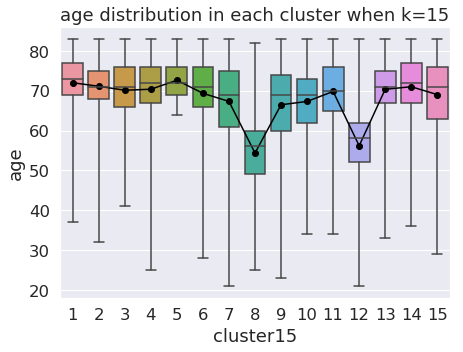

In [216]:
### can compare IQR
plt.figure(figsize=(7, 5))
sns.boxplot(x='cluster15', y ='age', data = validation_data, whis=10)
cluster15_age = validation_data.groupby('cluster15').age.mean()
plt.plot(cluster15_age.index -1, cluster15_age.values, 'o-', color = 'black')
plt.title('age distribution in each cluster when k=15')
plt.show()

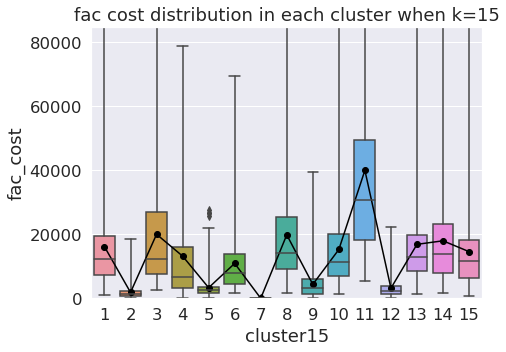

In [218]:
### can compare IQR
plt.figure(figsize=(7, 5))
plt.ylim((0, np.percentile(validation_data.fac_cost, 99)))
sns.boxplot(x='cluster15', y ='fac_cost', data = validation_data, whis=10)
cluster15_fac = validation_data.groupby('cluster15').fac_cost.mean()
plt.plot(cluster15_fac.index -1, cluster15_fac.values, 'o-', color = 'black')
plt.title('fac cost distribution in each cluster when k=15')
plt.show()

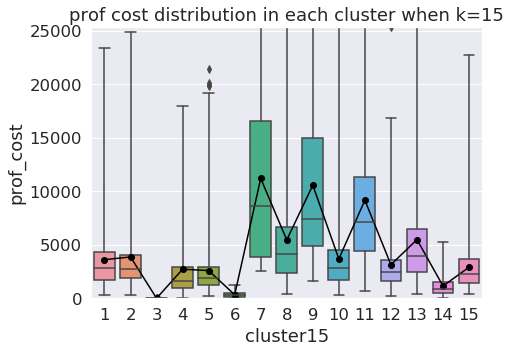

In [221]:
### can compare IQR
plt.figure(figsize=(7, 5))
plt.ylim((0, np.percentile(validation_data.prof_cost, 99)))
sns.boxplot(x='cluster15', y ='prof_cost', data = validation_data, whis=10)
cluster15_prof = validation_data.groupby('cluster15').prof_cost.mean()
plt.plot(cluster15_prof.index -1, cluster15_prof.values, 'o-', color = 'black')
plt.title('prof cost distribution in each cluster when k=15')
plt.show()

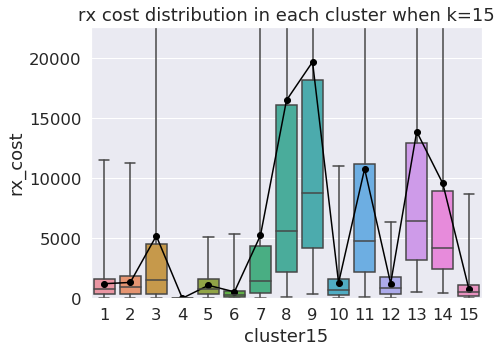

In [224]:
### can compare IQR
plt.figure(figsize=(7, 5))
plt.ylim((0, np.percentile(validation_data.rx_cost, 95)))
sns.boxplot(x='cluster15', y ='rx_cost', data = validation_data, whis=10)
cluster15_rx = validation_data.groupby('cluster15').rx_cost.mean()
plt.plot(cluster15_rx.index -1, cluster15_rx.values, 'o-', color = 'black')
plt.title('rx cost distribution in each cluster when k=15')
plt.show()

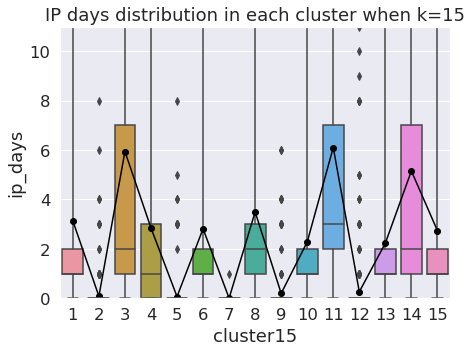

In [225]:
### can compare IQR
plt.figure(figsize=(7, 5))
plt.ylim((0, np.percentile(validation_data.ip_days, 95)))
sns.boxplot(x='cluster15', y ='ip_days', data = validation_data, whis=10)
cluster15_ip = validation_data.groupby('cluster15').ip_days.mean()
plt.plot(cluster15_ip.index -1, cluster15_ip.values, 'o-', color = 'black')
plt.title('IP days distribution in each cluster when k=15')
plt.show()

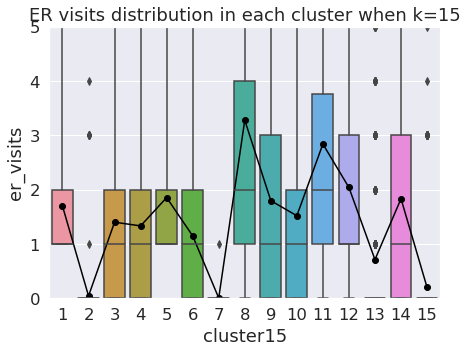

In [226]:
### can compare IQR
plt.figure(figsize=(7, 5))
plt.ylim((0, np.percentile(validation_data.er_visits, 95)))
sns.boxplot(x='cluster15', y ='er_visits', data = validation_data, whis=10)
cluster15_er = validation_data.groupby('cluster15').er_visits.mean()
plt.plot(cluster15_er.index -1, cluster15_er.values, 'o-', color = 'black')
plt.title('ER visits distribution in each cluster when k=15')
plt.show()

In [232]:
### relative importance of segment attributes k =15
cluster_avg = validation_data[original_cols+ ['cluster15']].groupby('cluster15').mean()
population_avg = validation_data[original_cols].mean()
relative_imp = cluster_avg/population_avg - 1

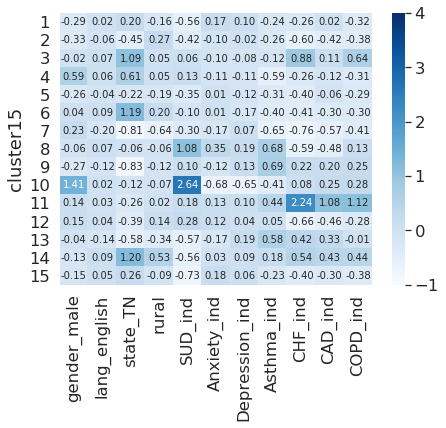

In [233]:
plt.figure(figsize=(7, 5))
sns.heatmap(relative_imp.iloc[:,:11], annot=True, fmt='.2f', vmin=-1.0, vmax=4, cmap ='Blues') #

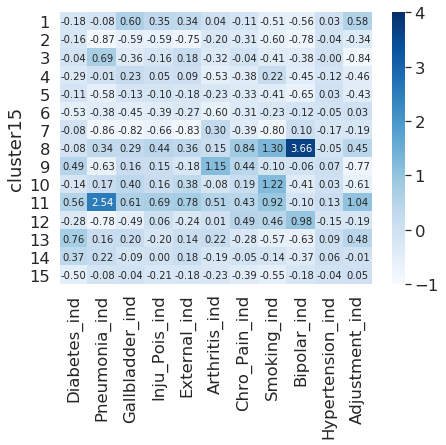

In [234]:
plt.figure(figsize=(7, 5))
sns.heatmap(relative_imp.iloc[:,11:22], annot=True, fmt='.2f', vmin=-1.0, vmax=4, cmap ='Blues') # 

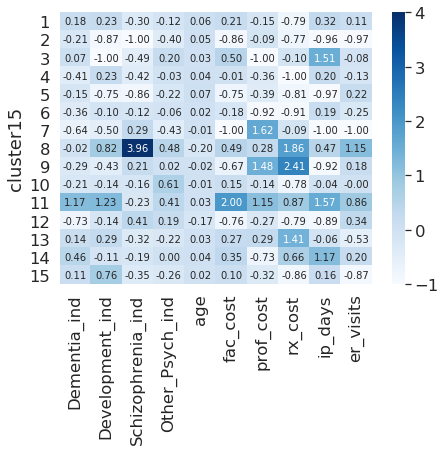

In [235]:
plt.figure(figsize=(7, 5))
sns.heatmap(relative_imp.iloc[:,22:], annot=True, fmt='.2f', vmin=-1.0, vmax=4, cmap ='Blues') #

In [236]:
## evaluate K == 20 clusters

In [265]:
cluster_size = pd.Series(cluster_labels20).value_counts().sort_index()
zip(cluster_size.index, cluster_size.values)

[(1, 367),
 (2, 470),
 (3, 272),
 (4, 423),
 (5, 191),
 (6, 412),
 (7, 235),
 (8, 313),
 (9, 164),
 (10, 430),
 (11, 392),
 (12, 329),
 (13, 434),
 (14, 397),
 (15, 394),
 (16, 278),
 (17, 389),
 (18, 505),
 (19, 413),
 (20, 280)]

In [237]:

nClusters = 20

for i in range(len(original_dummy_cols)):
    benchMark = validation_data[original_dummy_cols[i]].mean()
    print('')
    print('----------' + original_dummy_cols[i] + ' bench mark is: ' + str(round(benchMark,3)) + '---------------')
    print('')
    for j in range(1, nClusters+1):
        successInCluster = validation_data[validation_data.cluster20 == j][original_dummy_cols[i]].sum()
        trialInCluster = (validation_data.cluster20 == j).sum()
        failureInCluster = trialInCluster - successInCluster
        if ((successInCluster >= 5) &  (failureInCluster >=5)):
            pValue = stats.binom_test(successInCluster, n = trialInCluster, p=benchMark)
            if (pValue < 0.05):
                diff = round(abs((successInCluster*1.0/trialInCluster - benchMark)),3)
                if (successInCluster*1.0/trialInCluster > benchMark):
                    print(original_dummy_cols[i] + ' in cluster ' + str(j) + ' is bigger than bench mark by ' + str(diff) )
                else:
                    print(original_dummy_cols[i] + ' in cluster ' + str(j) + ' is smaller than bench mark by ' + str(diff))
            else:
                print(original_dummy_cols[i] + ' in cluster ' + str(j) + ' is not significant')
        else:
            print('perfect seperation, can not perform binomial test for ' + original_dummy_cols[i] + ' in cluster ' + str(j))
            print(original_dummy_cols[i] + ' positive: '+ str(successInCluster) + ', negative: '+ str(failureInCluster))






----------gender_male bench mark is: 0.342---------------

gender_male in cluster 1 is bigger than bench mark by 0.135
gender_male in cluster 2 is smaller than bench mark by 0.11
gender_male in cluster 3 is not significant
gender_male in cluster 4 is smaller than bench mark by 0.134
gender_male in cluster 5 is bigger than bench mark by 0.082
gender_male in cluster 6 is bigger than bench mark by 0.185
gender_male in cluster 7 is bigger than bench mark by 0.194
gender_male in cluster 8 is bigger than bench mark by 0.342
gender_male in cluster 9 is not significant
gender_male in cluster 10 is not significant
gender_male in cluster 11 is smaller than bench mark by 0.082
gender_male in cluster 12 is not significant
gender_male in cluster 13 is smaller than bench mark by 0.167
gender_male in cluster 14 is smaller than bench mark by 0.09
gender_male in cluster 15 is not significant
gender_male in cluster 16 is bigger than bench mark by 0.489
gender_male in cluster 17 is smaller than bench ma

CHF_ind in cluster 17 is smaller than bench mark by 0.112
CHF_ind in cluster 18 is smaller than bench mark by 0.166
CHF_ind in cluster 19 is bigger than bench mark by 0.094
CHF_ind in cluster 20 is smaller than bench mark by 0.089

----------CAD_ind bench mark is: 0.398---------------

CAD_ind in cluster 1 is bigger than bench mark by 0.417
CAD_ind in cluster 2 is smaller than bench mark by 0.113
CAD_ind in cluster 3 is smaller than bench mark by 0.118
CAD_ind in cluster 4 is smaller than bench mark by 0.062
CAD_ind in cluster 5 is smaller than bench mark by 0.236
CAD_ind in cluster 6 is smaller than bench mark by 0.201
CAD_ind in cluster 7 is not significant
CAD_ind in cluster 8 is not significant
CAD_ind in cluster 9 is not significant
CAD_ind in cluster 10 is smaller than bench mark by 0.189
CAD_ind in cluster 11 is bigger than bench mark by 0.158
CAD_ind in cluster 12 is bigger than bench mark by 0.082
CAD_ind in cluster 13 is bigger than bench mark by 0.157
CAD_ind in cluster 14 i

External_ind in cluster 12 is smaller than bench mark by 0.116
External_ind in cluster 13 is smaller than bench mark by 0.06
External_ind in cluster 14 is bigger than bench mark by 0.211
External_ind in cluster 15 is bigger than bench mark by 0.115
External_ind in cluster 16 is bigger than bench mark by 0.171
External_ind in cluster 17 is smaller than bench mark by 0.106
External_ind in cluster 18 is smaller than bench mark by 0.367
External_ind in cluster 19 is bigger than bench mark by 0.058
External_ind in cluster 20 is smaller than bench mark by 0.345

----------Arthritis_ind bench mark is: 0.071---------------

Arthritis_ind in cluster 1 is not significant
Arthritis_ind in cluster 2 is smaller than bench mark by 0.028
Arthritis_ind in cluster 3 is smaller than bench mark by 0.049
Arthritis_ind in cluster 4 is not significant
Arthritis_ind in cluster 5 is not significant
Arthritis_ind in cluster 6 is not significant
Arthritis_ind in cluster 7 is smaller than bench mark by 0.037
Art

Dementia_ind in cluster 12 is not significant
Dementia_ind in cluster 13 is not significant
Dementia_ind in cluster 14 is not significant
Dementia_ind in cluster 15 is bigger than bench mark by 0.027
perfect seperation, can not perform binomial test for Dementia_ind in cluster 16
Dementia_ind positive: 4, negative: 274
Dementia_ind in cluster 17 is not significant
Dementia_ind in cluster 18 is not significant
Dementia_ind in cluster 19 is not significant
perfect seperation, can not perform binomial test for Dementia_ind in cluster 20
Dementia_ind positive: 4, negative: 276

----------Development_ind bench mark is: 0.02---------------

Development_ind in cluster 1 is bigger than bench mark by 0.031
perfect seperation, can not perform binomial test for Development_ind in cluster 2
Development_ind positive: 4, negative: 466
Development_ind in cluster 3 is not significant
Development_ind in cluster 4 is not significant
perfect seperation, can not perform binomial test for Development_ind i

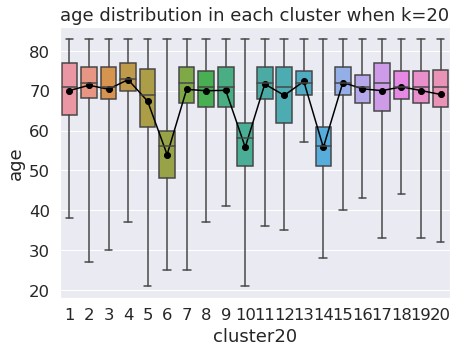

In [238]:
### can compare IQR
plt.figure(figsize=(7, 5))
sns.boxplot(x='cluster20', y ='age', data = validation_data, whis=10)
cluster20_age = validation_data.groupby('cluster20').age.mean()
plt.plot(cluster20_age.index -1, cluster20_age.values, 'o-', color = 'black')
plt.title('age distribution in each cluster when k=20')
plt.show()

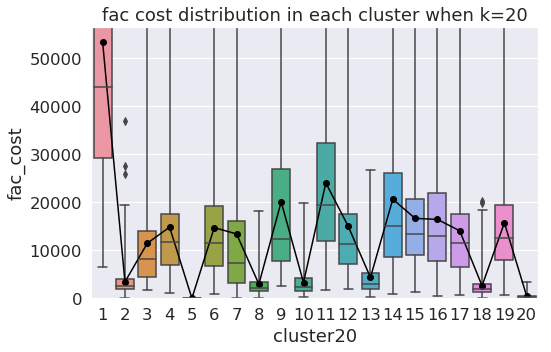

In [266]:
### can compare IQR
plt.figure(figsize=(8, 5))
plt.ylim((0, np.percentile(validation_data.fac_cost, 97)))
sns.boxplot(x='cluster20', y ='fac_cost', data = validation_data, whis=10)
cluster20_fac = validation_data.groupby('cluster20').fac_cost.mean()
plt.plot(cluster20_fac.index -1, cluster20_fac.values, 'o-', color = 'black')
plt.title('fac cost distribution in each cluster when k=20')
plt.show()

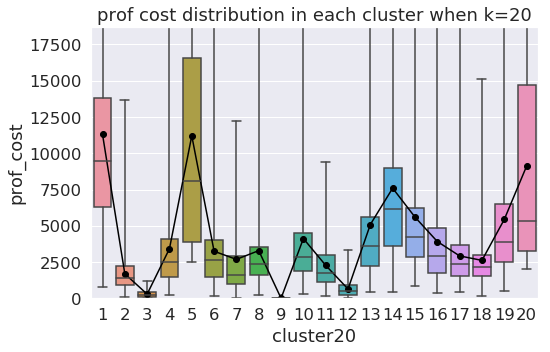

In [267]:
### can compare IQR
plt.figure(figsize=(8, 5))
plt.ylim((0, np.percentile(validation_data.prof_cost, 97)))
sns.boxplot(x='cluster20', y ='prof_cost', data = validation_data, whis=10)
cluster20_prof = validation_data.groupby('cluster20').prof_cost.mean()
plt.plot(cluster20_prof.index -1, cluster20_prof.values, 'o-', color = 'black')
plt.title('prof cost distribution in each cluster when k=20')
plt.show()

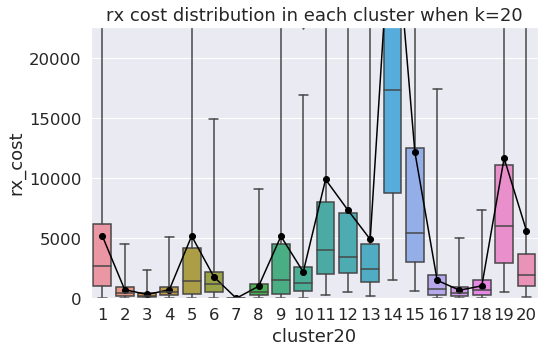

In [274]:
### can compare IQR
plt.figure(figsize=(8, 5))
plt.ylim((0, np.percentile(validation_data.rx_cost, 95)))
sns.boxplot(x='cluster20', y ='rx_cost', data = validation_data, whis=10)
cluster20_rx = validation_data.groupby('cluster20').rx_cost.mean()
plt.plot(cluster20_rx.index -1, cluster20_rx.values, 'o-', color = 'black')
plt.title('rx cost distribution in each cluster when k=20')
plt.show()

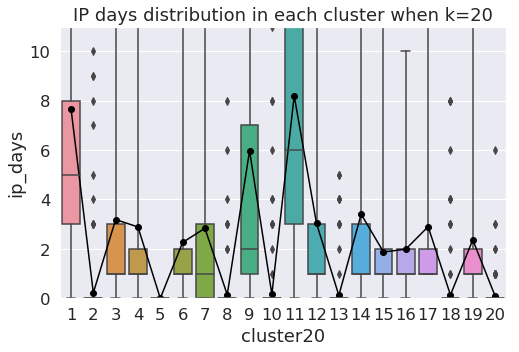

In [275]:
### can compare IQR
plt.figure(figsize=(8, 5))
plt.ylim((0, np.percentile(validation_data.ip_days, 95)))
sns.boxplot(x='cluster20', y ='ip_days', data = validation_data, whis=10)
cluster20_ip = validation_data.groupby('cluster20').ip_days.mean()
plt.plot(cluster20_ip.index -1, cluster20_ip.values, 'o-', color = 'black')
plt.title('IP days distribution in each cluster when k=20')
plt.show()

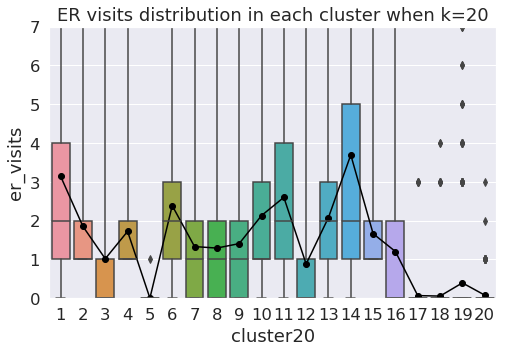

In [276]:
### can compare IQR
plt.figure(figsize=(8, 5))
plt.ylim((0, np.percentile(validation_data.er_visits, 97)))
sns.boxplot(x='cluster20', y ='er_visits', data = validation_data, whis=10)
cluster20_er = validation_data.groupby('cluster20').er_visits.mean()
plt.plot(cluster20_er.index -1, cluster20_er.values, 'o-', color = 'black')
plt.title('ER visits distribution in each cluster when k=20')
plt.show()

In [261]:
### relative importance of segment attributes k =15
cluster_avg = validation_data[original_cols+ ['cluster20']].groupby('cluster20').mean()
population_avg = validation_data[original_cols].mean()
relative_imp = cluster_avg/population_avg - 1

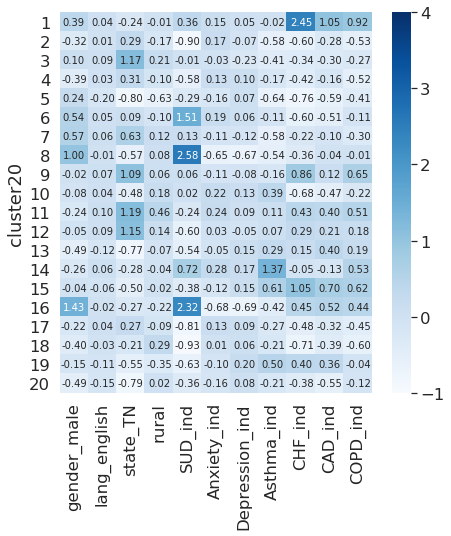

In [262]:
plt.figure(figsize=(7, 7))
sns.heatmap(relative_imp.iloc[:,:11], annot=True, fmt='.2f', vmin=-1.0, vmax=4, cmap ='Blues') #

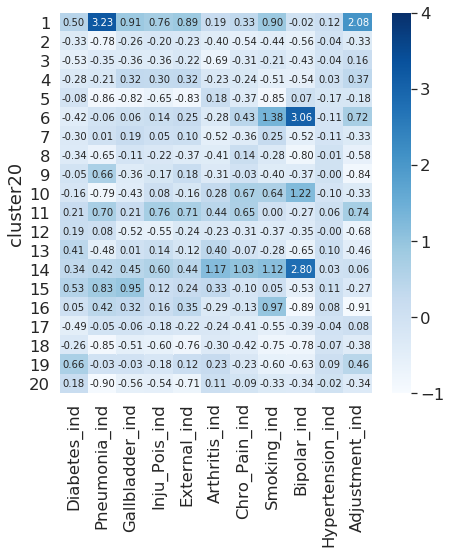

In [263]:
plt.figure(figsize=(7, 7))
sns.heatmap(relative_imp.iloc[:,11:22], annot=True, fmt='.2f', vmin=-1.0, vmax=4, cmap ='Blues') #

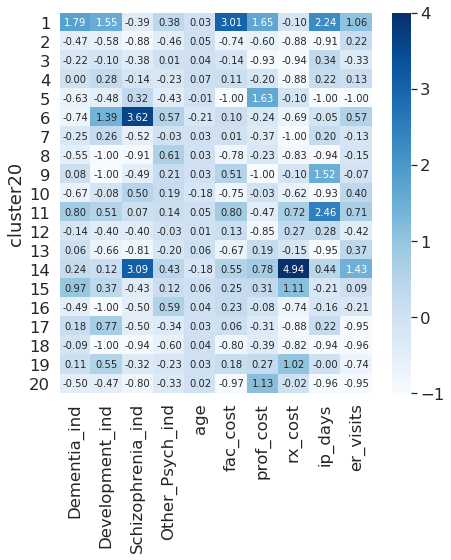

In [264]:
plt.figure(figsize=(7, 7))
sns.heatmap(relative_imp.iloc[:, 22:], annot=True, fmt='.2f', vmin=-1.0, vmax=4, cmap ='Blues') #

In [ ]:
## evaluate K == 25 clusters

In [ ]:
## evaluate K == 30 clusters

In [ ]:
## evaluate K == 35 clusters

In [ ]:
## evaluate K == 40 clusters

In [ ]:
## evaluate K == 45 clusters

In [ ]:
## evaluate K == 50 clusters